In [1]:
# %load_ext autoreload
import importlib
import pandas as pd
import os
import sys
import pwd
import numpy as np
from pathlib import Path
from tqdm import tqdm, trange
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
# import GEOparse
import scanpy as sc
from scipy import sparse as sp
import sparse as spa
import scipy as spy
sys.path.append('../')

from scipy.stats import linregress, entropy
from meth import tools as mtools
from meth import analytic_tools as anatools
from meth.meth_anndata import AnnDataSet
from scipy.stats import pearsonr 
import sctools as sct

%load_ext autoreload
%autoreload 2
plt.style.use('meth.mplstyle')

2024-01-24 06:58:30.741 | ℹ️ Welcome to sctools! Stay white-pilled!

M       M   AAAAA   L       AAAAA  TTTTTTT   1
MM     MM  A     A  L      A     A    T      1
M M   M M  AAAAAAA  L      AAAAAAA    T      1
M  M M  M  A     A  L      A     A    T      1
M   M   M  A     A  LLLLL  A     A    T     111



In [2]:
cwd = Path.cwd()
cwd_base = Path('/Users/tarkhov/Dropbox/Harvard/Science/')
#project_dir = Path.joinpath(cwd, Path('data/GSE121436/'))
cwd_bulk = Path('/Users/tarkhov/Dropbox/Harvard/Science/Stochastic aging/')
#project_dir = Path.joinpath(cwd_bulk, Path('data/GSE121436/'))

dsets = {}
coverage = 0 
binned_by = 10

# dump_key="thresh_5_common_cpgs"
# dump_key="thresh_5_common_cpgs_only_coreg_and_stochastic_dynamics"
dump_key="thresh_5_common_cpgsthresh_5_common_cpgs_only_coreg_and_stochastic_dynamics"
# dump_key=""
# paths = {
#         'scMiceMuscle': Path.joinpath(cwd, Path(f'data/GSE121436/GSE121436_wmeta_mm10{dump_key}.h5ad')), #mm10
#          'scBulkedMiceMuscle': Path.joinpath(cwd, Path(f'data/GSE121436/GSE121436_bulked_wmeta_mm10{dump_key}.h5ad')), 
#         }

paths = {
        'scMiceMuscle': sct.io.uget(f'gs://retro-personal-andrei/scDNAm/scDNAm/data/GSE121436/GSE121436_wmeta_mm10{dump_key}.h5ad'), #mm10
         'scBulkedMiceMuscle': sct.io.uget(f'gs://retro-personal-andrei/scDNAm/scDNAm/data/GSE121436/GSE121436_bulked_wmeta_mm10{dump_key}.h5ad'), 
        # 'scMiceMuscle': sct.io.uget(f'gs://retro-personal-andrei/scDNAm/scDNAm/data/GSE121436/GSE121436_wmeta_mm10{dump_key}.h5ad'), #mm10
        #  'scBulkedMiceMuscle': sct.io.uget(f'gs://retro-personal-andrei/scDNAm/scDNAm/data/GSE121436/GSE121436_bulked_wmeta_mm10{dump_key}.h5ad'), 
}

2024-01-24 06:58:35.960 | ℹ️ You can now replace your function call with the following for reproducibility:
uget('gs://retro-personal-andrei/scDNAm/scDNAm/data/GSE121436/GSE121436_wmeta_mm10thresh_5_common_cpgsthresh_5_common_cpgs_only_coreg_and_stochastic_dynamics.h5ad', checksum='JOK51ZVLnNOcsVGCC549sg==')


2024-01-24 06:58:36.578 | ℹ️ You can now replace your function call with the following for reproducibility:
uget('gs://retro-personal-andrei/scDNAm/scDNAm/data/GSE121436/GSE121436_bulked_wmeta_mm10thresh_5_common_cpgsthresh_5_common_cpgs_only_coreg_and_stochastic_dynamics.h5ad', checksum='QAH5o0NTLe/DpRKIaVFy2Q==')


In [3]:
all_dsets = AnnDataSet(paths=paths)

Genes before 103790, and after merging scMiceMuscle: 103790
Genes before 103790, and after merging scBulkedMiceMuscle: 103790
Common genes number: 103790


In [4]:
all_dsets.update_dsets_view("full", "common_cpgs")

In [5]:

key_sc = 'scMiceMuscle'
key_bu = 'scBulkedMiceMuscle'
key_sc_bu = 'scBulkedMiceMuscle'

idx_per = np.arange(0, all_dsets.dsets_red[key_sc].X.shape[0], 2).astype(int)
idx_cov = np.arange(1, all_dsets.dsets_red[key_sc].X.shape[0], 2).astype(int)

X = all_dsets.dsets_red[key_sc].X[idx_per,:]
Xcov = all_dsets.dsets_red[key_sc].X[idx_cov,:]
print(X.shape)
n_cover = np.sum(Xcov > 0.5, axis=0)
n_cover = np.array(n_cover).flatten()
sum_cov = np.sum(Xcov, axis=0)
cover = sum_cov / n_cover

th = 15.
# th = 0.5
# print(np.sum(cover >= th), np.sum(cover < th))
print(np.sum(n_cover >= th), np.sum(n_cover < th))

(275, 103790)
80916 22874


In [6]:
th = 15.
all_dsets.update_dsets_view("full", "common_cpgs")
idx_you = all_dsets.dsets_red[key_sc].obs['Age'].values < 10
idx_you = idx_you[::2]
n_cover_you = np.sum(Xcov[idx_you,:] > 0.5, axis=0)
n_cover_old = np.sum(Xcov[~idx_you,:] > 0.5, axis=0)
print(np.sum(np.logical_and(n_cover_you >= th, n_cover_old >=th)), np.sum(~np.logical_and(n_cover_you >= th, n_cover_old >=th)))

1318 102472


In [7]:
all_dsets.chosen_genes.shape, np.logical_and(n_cover_you >= th, n_cover_old >=th).shape

((103790,), (1, 103790))

In [8]:

idx_chosen = np.array(np.logical_and(n_cover_you >= th, n_cover_old >=th)).flatten()

print(np.sum(idx_chosen), np.sum(~idx_chosen))
mask_cpgs = all_dsets.chosen_genes[idx_chosen]
print(mask_cpgs.shape)

1318 102472
(1318,)


In [9]:
all_dsets.add_var_mask(var_mask=mask_cpgs, var_mask_name="cov>30cells")
all_dsets.update_dsets_view("full", "cov>30cells")

In [10]:
for association in ['meth']:
    all_dsets.find_aging_associations(#source_dsets=['Mice'], target_dsets=['Mice'], 
                                  #source_dsets=['scMiceMuscle'], 
                                  obs_mask_name='full', 
                                  # var_mask_name="prc2",
                                  var_mask_name="cov>30cells",
                                  #'common_cpgs', 
                                  association_name=association)

/home/jupyter/notebooks/scDNAm/meth/meth_anndata.py:200: RuntimeWarning: invalid value encountered in divide
  ba = ((1. * (ycov[:,idx] > 0.5)).multiply(b[:,idx]).multiply(y[:,idx]).sum(axis=1) - (1. * (ycov[:,idx] > 0.5)).multiply(x0[:,idx]).multiply(b[:,idx]).sum(axis=1)) / rescale_for_nans


In [11]:
all_dsets.update_dsets_view('full', 'cov>30cells')
# all_dsets.update_dsets_view('full', 'common_cpgs')
print(all_dsets.chosen_genes)

Index(['chr10_10585211', 'chr10_10653282', 'chr10_107845532',
       'chr10_107845594', 'chr10_110627667', 'chr10_110788171',
       'chr10_121994226', 'chr10_122631640', 'chr10_126367170',
       'chr10_126541027',
       ...
       'chrX_64763888', 'chrX_65540005', 'chrX_65966771', 'chrX_74024096',
       'chrX_78631591', 'chrX_9508992', 'chrX_96659635', 'chrY_44037547',
       'chrY_44473804', 'chrY_74574522'],
      dtype='object', name='index', length=1318)


In [12]:

idx_per = np.arange(0, all_dsets.dsets_red[key_sc].X.shape[0], 2).astype(int)
idx_cov = np.arange(1, all_dsets.dsets_red[key_sc].X.shape[0], 2).astype(int)
x = all_dsets.dsets[key_sc].obs.iloc[idx_per, :]['Mouse_ID']

X = all_dsets.dsets_red[key_sc].X[idx_per,:].toarray()
Xcov = all_dsets.dsets_red[key_sc].X[idx_cov,:].toarray()

# Plot with programmed stochastic changes

In [13]:
all_dsets.update_dsets_view('full', 'cov>30cells')

In [14]:
xsc = all_dsets.dsets_red[f'{key_sc}'].var[f'b_{key_sc}_full_cov>30cells_meth_sign'].abs() > 0.01

In [15]:
xbulk = all_dsets.dsets_red[f'{key_sc_bu}'].var[f'b_{key_sc_bu}_full_cov>30cells_meth_sign'].abs() > 0.01
print(xsc, xbulk)
print(xsc.sum(), xbulk.sum())

index
chr10_10585211      True
chr10_10653282      True
chr10_107845532     True
chr10_107845594    False
chr10_110627667    False
                   ...  
chrX_9508992        True
chrX_96659635      False
chrY_44037547      False
chrY_44473804       True
chrY_74574522       True
Name: b_scMiceMuscle_full_cov>30cells_meth_sign, Length: 1318, dtype: bool index
chr10_10585211      True
chr10_10653282      True
chr10_107845532     True
chr10_107845594    False
chr10_110627667    False
                   ...  
chrX_9508992        True
chrX_96659635      False
chrY_44037547      False
chrY_44473804       True
chrY_74574522       True
Name: b_scBulkedMiceMuscle_full_cov>30cells_meth_sign, Length: 1318, dtype: bool
519 502


In [16]:
idx_s_nz = np.nonzero(np.logical_and(xsc.values, xbulk.values))[0]

In [17]:
len(idx_s_nz)

502

In [18]:
all_dsets.update_dsets_view("full", "cov>30cells")

In [19]:
dset_base = key_sc_bu#'scMice'
age_filt = 'full'
cpg_filt = "cov>30cells"
#cpg_filt = 'common_cpgs'
data_trans = 'meth'

bioage = f'{dset_base}_{age_filt}_{cpg_filt}_{data_trans}'             

b_nonsign = all_dsets.dsets_red[f'{key_sc}'].var[f"r_{bioage}"].values
b_sign = all_dsets.dsets_red[f'{key_sc}'].var[f"r_{bioage}"].values

N_select = np.min([1000, len(idx_s_nz)])

np.random.shuffle(idx_s_nz)
irandom = idx_s_nz[:N_select]
b_s = np.zeros_like(b_sign)
b_s[irandom]= b_sign[irandom]

idx_ns_nz = np.nonzero(np.abs(b_nonsign) < 0.05)[0]
np.random.shuffle(idx_ns_nz)
irandom2 = idx_ns_nz[:N_select]
b_ns = np.zeros_like(b_nonsign)
b_ns[irandom2]= b_nonsign[irandom2]

In [20]:
idx_s = irandom
idx_ns = irandom2
idx_sel = np.hstack((idx_s, idx_ns)).flatten()
cpg_up = all_dsets.dsets_red[f'{key_sc}'].var.index[idx_s]
cpg_down = all_dsets.dsets_red[f'{key_sc}'].var.index[idx_ns]
print(cpg_up.shape, cpg_down.shape)

(502,) (502,)


In [21]:
all_dsets.add_var_mask(var_mask=all_dsets.dsets_red[f'{key_sc}'].var.index[idx_sel].tolist(), var_mask_name="cov>30cells_1000clockx1000random")
all_dsets.update_dsets_view("full", "cov>30cells_1000clockx1000random")

In [22]:
all_dsets.update_dsets_view("full", "cov>30cells_1000clockx1000random")
idx_per = np.arange(0, all_dsets.dsets_red[f'{key_sc}'].X.shape[0], 2).astype(int)
idx_cov = np.arange(1, all_dsets.dsets_red[f'{key_sc}'].X.shape[0], 2).astype(int)
X = all_dsets.dsets_red[f'{key_sc}'].X[idx_per,:]
Xcov = all_dsets.dsets_red[f'{key_sc}'].X[idx_cov,:]
t = all_dsets.dsets_red[f'{key_sc}'].obs['Age'].values[::2]

In [23]:
bioage = f'{dset_base}_{age_filt}_{cpg_filt}_{data_trans}'             

b_nonsign = all_dsets.dsets_red[key_sc].var[f"b_{bioage}_sign"].values
b_sign = all_dsets.dsets_red[key_sc].var[f"b_{bioage}_sign"].values
print(b_sign[b_sign > 1e-4].shape)
print(b_nonsign[b_nonsign < -1e-4].shape)

(121,)
(381,)


In [24]:
print(X.shape, Xcov.shape, t.shape)

(275, 1004) (275, 1004) (275,)


In [25]:
idx_sign = np.nonzero(b_sign > 1e-4)[0]
idx_nsign = np.nonzero(b_nonsign < -1e-4)[0]
print(idx_sign[:10], idx_nsign[:10])

[ 8 36 37 39 42 61 76 91 97 98] [ 0  1  2  4  9 13 18 19 20 22]


In [26]:
idx_sign = all_dsets.dsets_red[f'{key_sc}'].var.reset_index()['index'].isin(cpg_up).values
idx_nsign = all_dsets.dsets_red[f'{key_sc}'].var.reset_index()['index'].isin(cpg_down).values
# idx_sign, idx_nsign

In [27]:
ipos = all_dsets.dsets_red[f'{key_sc}'].var[f"b_{bioage}_sign"].iloc[idx_sign].values > 1e-4
ineg = all_dsets.dsets_red[f'{key_sc}'].var[f"b_{bioage}_sign"].iloc[idx_sign].values < -1e-4
ineutral = idx_nsign
print(ineutral.sum(), ipos.sum(), ineg.sum())


502 121 381


In [28]:
idx_neutral = np.nonzero(ineutral)[0]
idx_neutral_short = idx_neutral[:50]

idx_sorted_short = np.hstack((np.nonzero(ipos)[0][:50], np.nonzero(ineg)[0][:50]))
idx_sorted = np.hstack((np.nonzero(ipos)[0], np.nonzero(ineg)[0]))

idx_sorted_pos = np.nonzero(ipos)[0]
idx_sorted_neg = np.nonzero(ineg)[0]

# by mouse

In [29]:
if np.nanmax(X.data) > 1.1:
    x = np.array(X.todense())/100.
else:
    x = np.array(X.todense())
x[Xcov.toarray() < 0.5] = np.nan
idx = all_dsets.dsets_red[f'{key_sc}'].obs.iloc[::2,:].reset_index().sort_values(by = ['Age', 'Mouse_ID'], ascending = [True, False], na_position = 'first')[['Age', 'Mouse_ID']].index.tolist()
age = all_dsets.dsets_red[f'{key_sc}'].obs.iloc[::2,:]['Age'].values[idx]
x = x[idx,:]
params = all_dsets.dsets_red[f'{key_sc}'].obs.iloc[::2,:].iloc[idx,:][['Mouse_ID', 'Age']]
mouse_id = params.Mouse_ID.values
# direction = 'up'
# direction = 'down'
direction = 'both_ways'
# direction = 'neutral'
# print(params.Mouse_ID.unique())
figsize_for = {'up': (4,8),
               'down': (16,8),
               'neutral': (20,8),
               'both_ways': (20,8),
              }
xcov = Xcov.toarray()
xcov = xcov[idx]
if direction == 'up':
    xpos = x[:, idx_sign][:,idx_sorted_pos]
    xcov = xcov[:, idx_sign][:,idx_sorted_pos]
elif direction == 'down':
    xpos = x[:, idx_sign][:,idx_sorted_neg]
    xcov = xcov[:, idx_sign][:,idx_sorted_neg]
elif direction == 'neutral':
    xpos = x[:,idx_neutral]
    xcov = xcov[:,idx_neutral]
else:
    xpos = x[:, idx_sign][:,idx_sorted]
    xcov = xcov[:, idx_sign][:,idx_sorted]

In [30]:
xcov.shape, x.shape

((275, 502), (275, 1004))

# Gene sort by initial methylation

In [31]:
all_dsets.dsets_red[key_sc].var.index[440:460]

Index(['chr1_19214082', 'chr1_22874092', 'chr1_27195382', 'chr1_36531941',
       'chr1_36531976', 'chr1_3672035', 'chr1_36722152', 'chr1_43092217',
       'chr1_46313729', 'chr1_51562894', 'chr1_53784847', 'chr1_54856850',
       'chr1_56714519', 'chr1_56714544', 'chr1_59347474', 'chr1_6027014',
       'chr1_62220265', 'chr1_65418171', 'chr1_66969051', 'chr1_74601244'],
      dtype='object', name='index')

In [32]:
plt.style.use('default')
plt.style.use('meth.mplstyle')

In [33]:
xpos.shape, age.shape

from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression, ElasticNet, ElasticNetCV

las = Lasso()
las.fit(np.nan_to_num(xpos), age)

rid = ElasticNet(alpha=0.026, l1_ratio=0.5)
rid.fit(np.nan_to_num(xpos), age)


lasCV = LassoCV()
lasCV.fit(np.nan_to_num(xpos), age)

ridCV = ElasticNetCV(l1_ratio=0.5)
ridCV.fit(np.nan_to_num(xpos), age)


age_pred_las = las.predict(np.nan_to_num(xpos))
age_pred_lasCV = lasCV.predict(np.nan_to_num(xpos))
age_pred_rid = rid.predict(np.nan_to_num(xpos))
age_pred_ridCV = ridCV.predict(np.nan_to_num(xpos))


/home/jupyter/miniconda3/envs/scDNAm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.825e+00, tolerance: 1.996e+00
  model = cd_fast.enet_coordinate_descent(
/home/jupyter/miniconda3/envs/scDNAm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.372e+00, tolerance: 1.996e+00
  model = cd_fast.enet_coordinate_descent(
/home/jupyter/miniconda3/envs/scDNAm/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


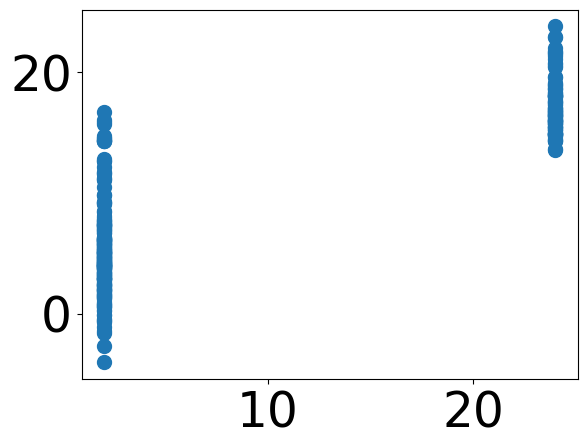

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


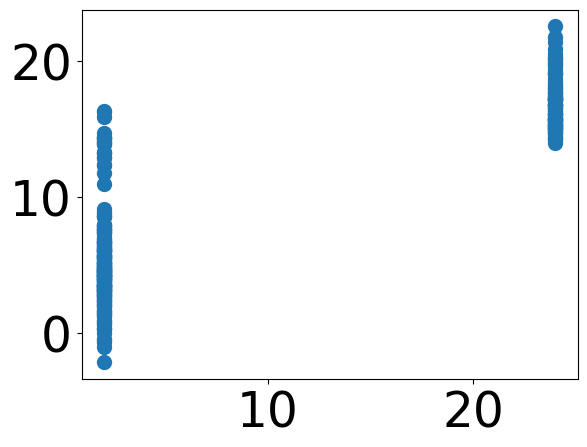

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


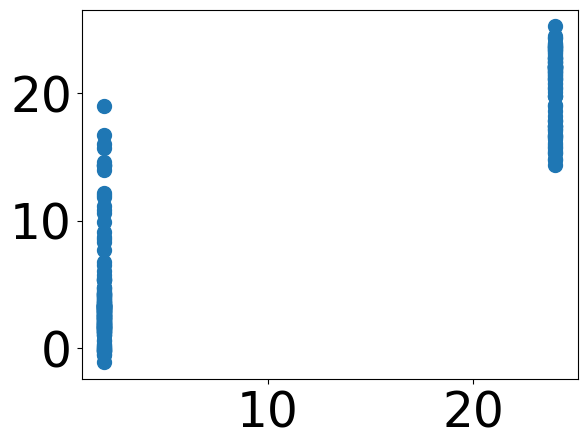

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


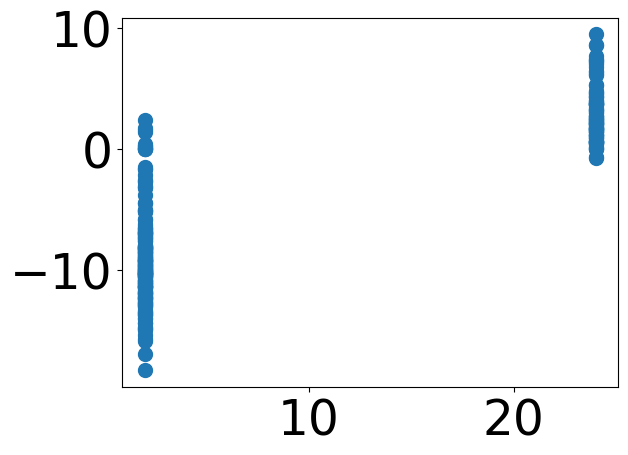

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


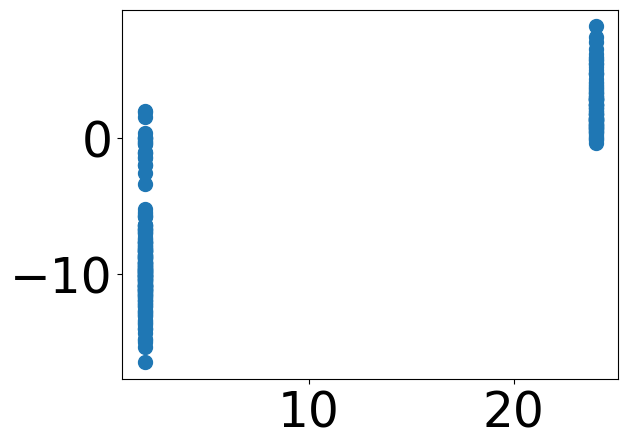

In [34]:
plt.scatter(age, age_pred_lasCV)
plt.show()

plt.scatter(age, age_pred_ridCV)
plt.show()
plt.scatter(age, age_pred_rid)
plt.show()

plt.scatter(age, np.dot(np.nan_to_num(xpos), lasCV.coef_))
plt.show()
plt.scatter(age, np.dot(np.nan_to_num(xpos), ridCV.coef_))
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


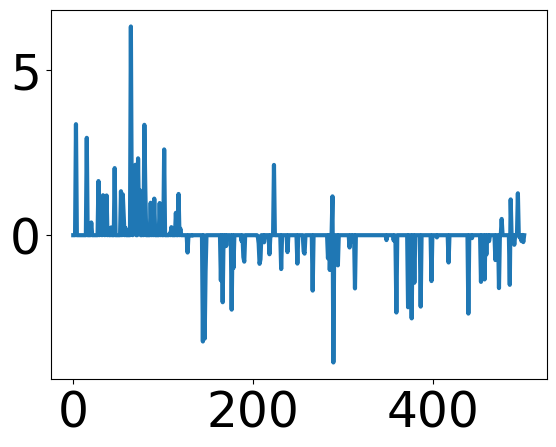

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


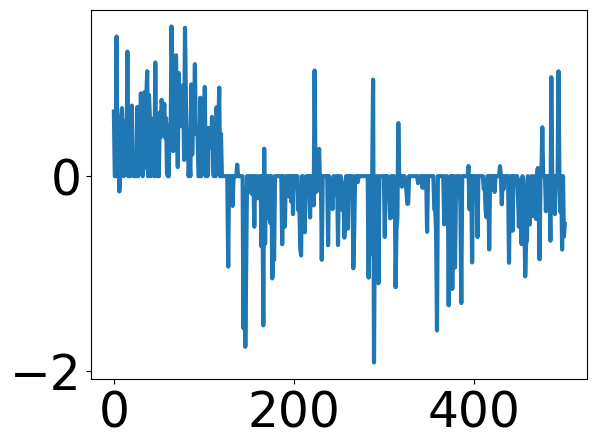

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


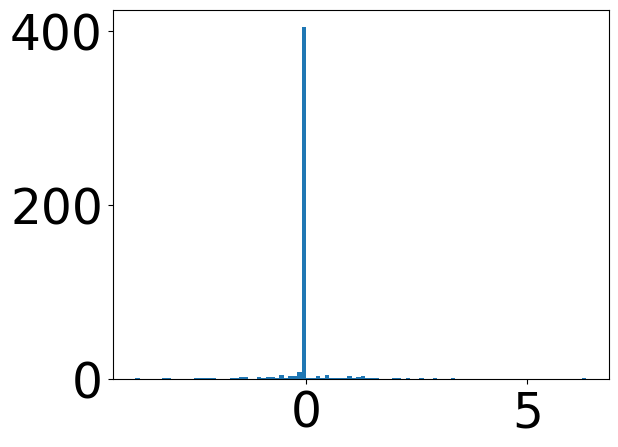

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


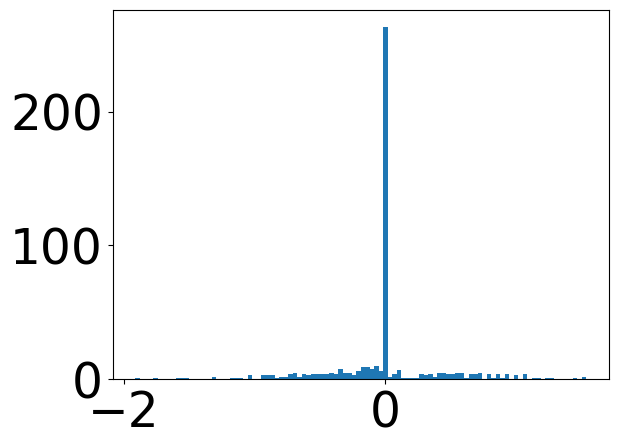

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


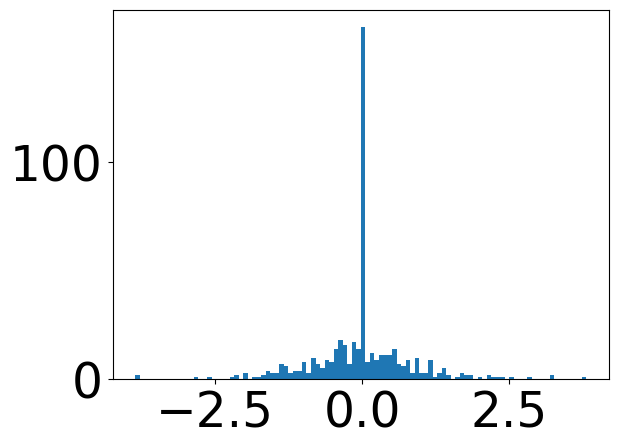

In [35]:
lasCV.coef_, ridCV.coef_

plt.plot(lasCV.coef_)
plt.show()
plt.plot(ridCV.coef_)
plt.show()

plt.hist(lasCV.coef_, bins=100)
plt.show()

plt.hist(ridCV.coef_, bins=100)
plt.show()

plt.hist(rid.coef_, bins=100)
plt.show()

In [36]:
lasco = lasCV.coef_.copy()
lasco[np.abs(lasco) < 1e-2] = np.nan

ridco = ridCV.coef_.copy()
ridco[np.abs(ridco) < 1e-2] = np.nan

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


['Y8', 'Y7', 'Y2', 'O5', 'O8', 'O1']
Categories (6, object): ['O1', 'O5', 'O8', 'Y2', 'Y7', 'Y8']
['Y2', 'Y7', 'Y8', 'O5', 'O1', 'O8']


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

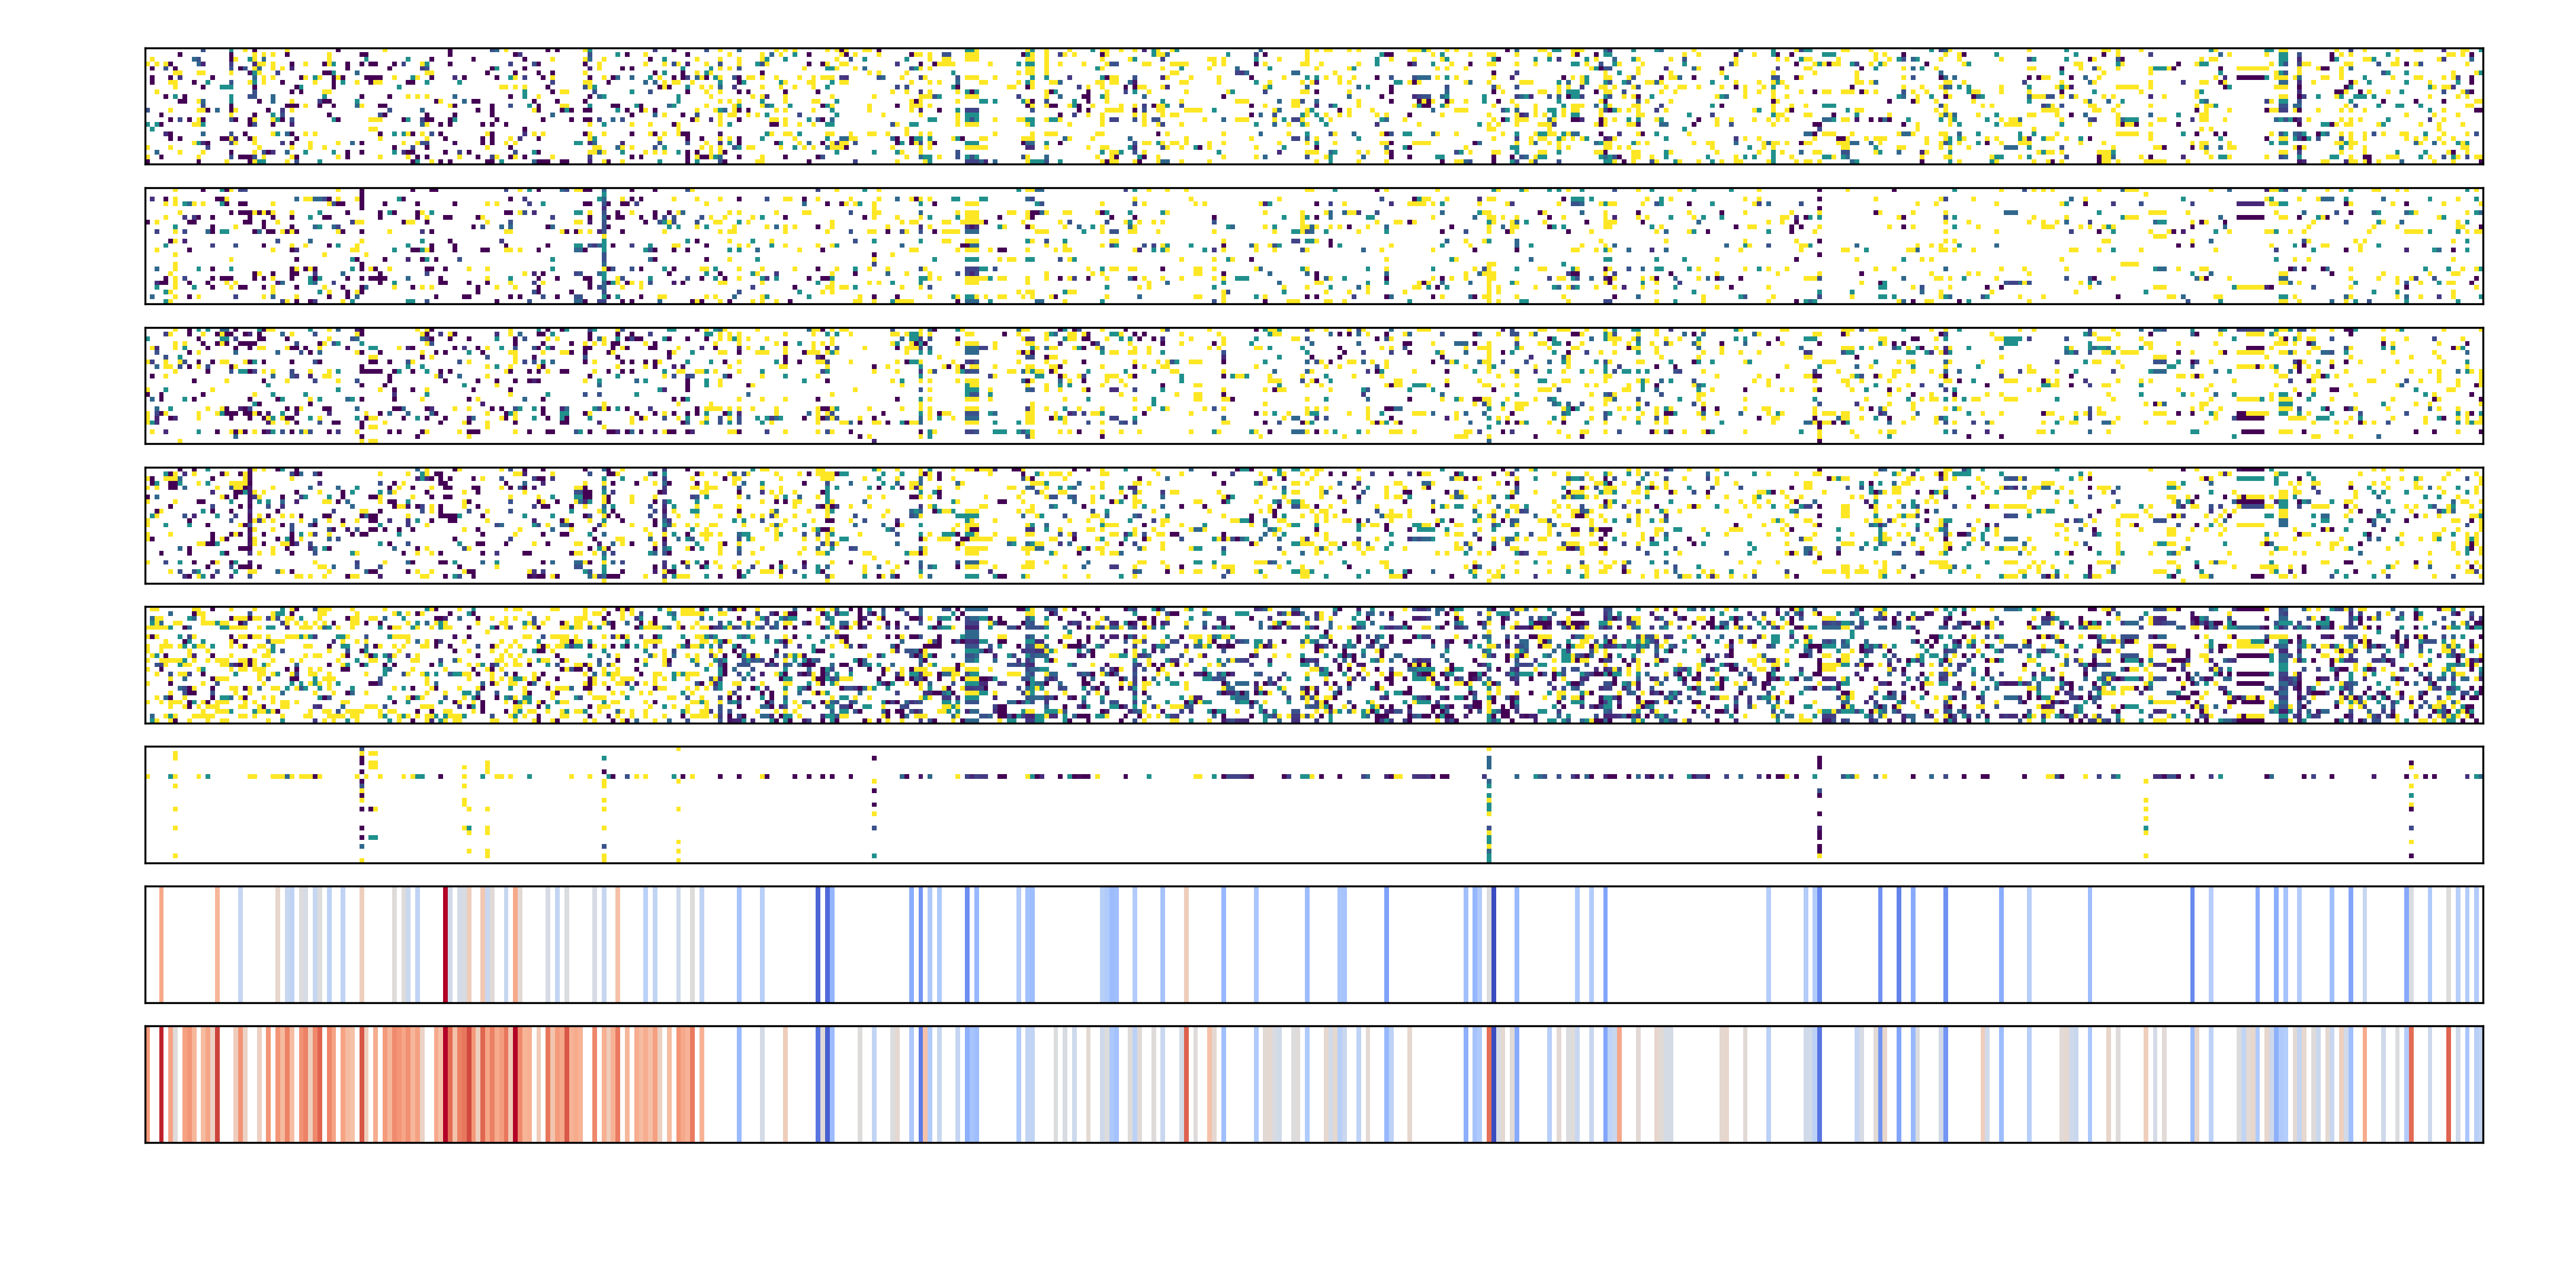

In [37]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['Y2', 'Y7', 'Y8', 'O5', 'O1', 'O8']
mice_young = ['Y2', 'Y7', 'Y8', 'O5']
print(mice)
fig, ax = plt.subplots(len(mice) + 2,1, #figsize=(7,7),
                       figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse)
[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]

ax[-2].imshow(np.broadcast_to(lasco, (25,lasco.shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco, (25,ridco.shape[0])), cmap='coolwarm')
plt.savefig(f'PICS/png/Th15_full_{direction}.png', format='png', dpi=300)
plt.show()

In [38]:
idx_you = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age < 10)
idx_old = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age > 10)
print(xpos.shape, np.sum(idx_you), np.sum(idx_old))

(275, 502) 181 85


# Correlation filter for coregulation regions

In [39]:
# def convert_to_float16(res):
#     return res[0].astype(np.float16), res[1].astype(np.float16)

# nbatch = xpos.shape[1] // batch + 1
# for i in trange(nbatch):
#     idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos_sp.shape[1]]))
#     data, cov = convert_to_float16(anatools.corr_mat_by_batch_fast(xpos_sp, xcov_sp, idx=idx))
#     with h5py.File(f'dumps/{filename}.h5', 'a') as hf:
#         save2hdf(hf, data, cov, batch_id=i)
#     gc.collect()

In [40]:


idx_you = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age < 10)
idx_old = np.logical_and(np.nansum(~np.isnan(xpos), axis=1) > 2, age > 10)

ag_corr_old = np.zeros((xpos.shape[1], xpos.shape[1]))
ag_cov_norm_old = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 502
nbatch = xpos.shape[1] // batch + 1
xpos_sp = np.nan_to_num(xpos[idx_old]).astype(np.float64)
xcov_sp = np.nan_to_num(xcov[idx_old]).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_old[idx], ag_cov_norm_old[idx] = anatools.corr_mat_by_batch_fast(xpos_sp, xcov_sp, idx=idx)
    
ag_corr_you = np.zeros((xpos.shape[1], xpos.shape[1]))
ag_cov_norm_you = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 502
nbatch = xpos.shape[1] // batch + 1
xpos_sp = np.nan_to_num(xpos[idx_you]).astype(np.float64)
xcov_sp = np.nan_to_num(xcov[idx_you]).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr_you[idx], ag_cov_norm_you[idx] = anatools.corr_mat_by_batch_fast(xpos_sp, xcov_sp, idx=idx)
    
ag_corr = np.zeros((xpos.shape[1], xpos.shape[1]))
ag_cov_norm = np.zeros((xpos.shape[1], xpos.shape[1]))
batch = 502
nbatch = xpos.shape[1] // batch + 1
xpos_sp = np.nan_to_num(xpos).astype(np.float64)
xcov_sp = np.nan_to_num(xcov).astype(np.float64)
for i in trange(nbatch):
    idx = np.arange(i * batch, np.min([ (i + 1) * batch, xpos.shape[1]]))
    ag_corr[idx], ag_cov_norm[idx] = anatools.corr_mat_by_batch_fast(xpos_sp, xcov_sp, idx=idx)

  0%|          | 0/2 [00:00<?, ?it/s]/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:972: RuntimeWarning: divide by zero encountered in divide
  cov_denomin = 1. / np.sqrt(cov_denomin)
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:973: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov * cov_denomin[:, jdx]
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:974: RuntimeWarning: invalid value encountered in multiply
  cov_mat = cov_denomin[:, idx].T * cov_mat
/home/jupyter/notebooks/scDNAm/meth/analytic_tools.py:975: RuntimeWarning: divide by zero encountered in divide
  cov_norm = 1. / cov_norm
100%|██████████| 2/2 [00:00<00:00, 67.09it/s]


In [41]:
corr_ths = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
numcoreg = []
for corr_th in corr_ths:#= 0.5
    jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
    clusters = []
    cluster_sizes = []
    for i in trange(ag_corr.shape[0]):
        idx = np.abs(ag_corr[i,:]) > corr_th
        idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
        idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
        idx = np.logical_and(idx, idx_old_cpg)
        idx = np.logical_and(idx, idx_you_cpg)
        # cluster_sizes.append(np.sum(idx))
        # clusters.append(np.nonzero(idx)[0])
        # if (np.sum(idx) > 1.5) and (np.sum(idx_you) > 1.5) and (np.sum(idx_old) > 1.5):
        if (np.sum(idx) > 1.5):
            jdx_coreg[idx] = True
    print(np.sum(jdx_coreg))
    numcoreg.append(np.sum(jdx_coreg))

100%|██████████| 502/502 [00:00<00:00, 26662.20it/s]


500


100%|██████████| 502/502 [00:00<00:00, 53970.23it/s]


248


100%|██████████| 502/502 [00:00<00:00, 58047.05it/s]


66


100%|██████████| 502/502 [00:00<00:00, 59207.60it/s]


56


100%|██████████| 502/502 [00:00<00:00, 60370.46it/s]


40


100%|██████████| 502/502 [00:00<00:00, 58653.42it/s]


22


100%|██████████| 502/502 [00:00<00:00, 58718.85it/s]


15


100%|██████████| 502/502 [00:00<00:00, 59029.99it/s]


6


100%|██████████| 502/502 [00:00<00:00, 55108.77it/s]


4


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

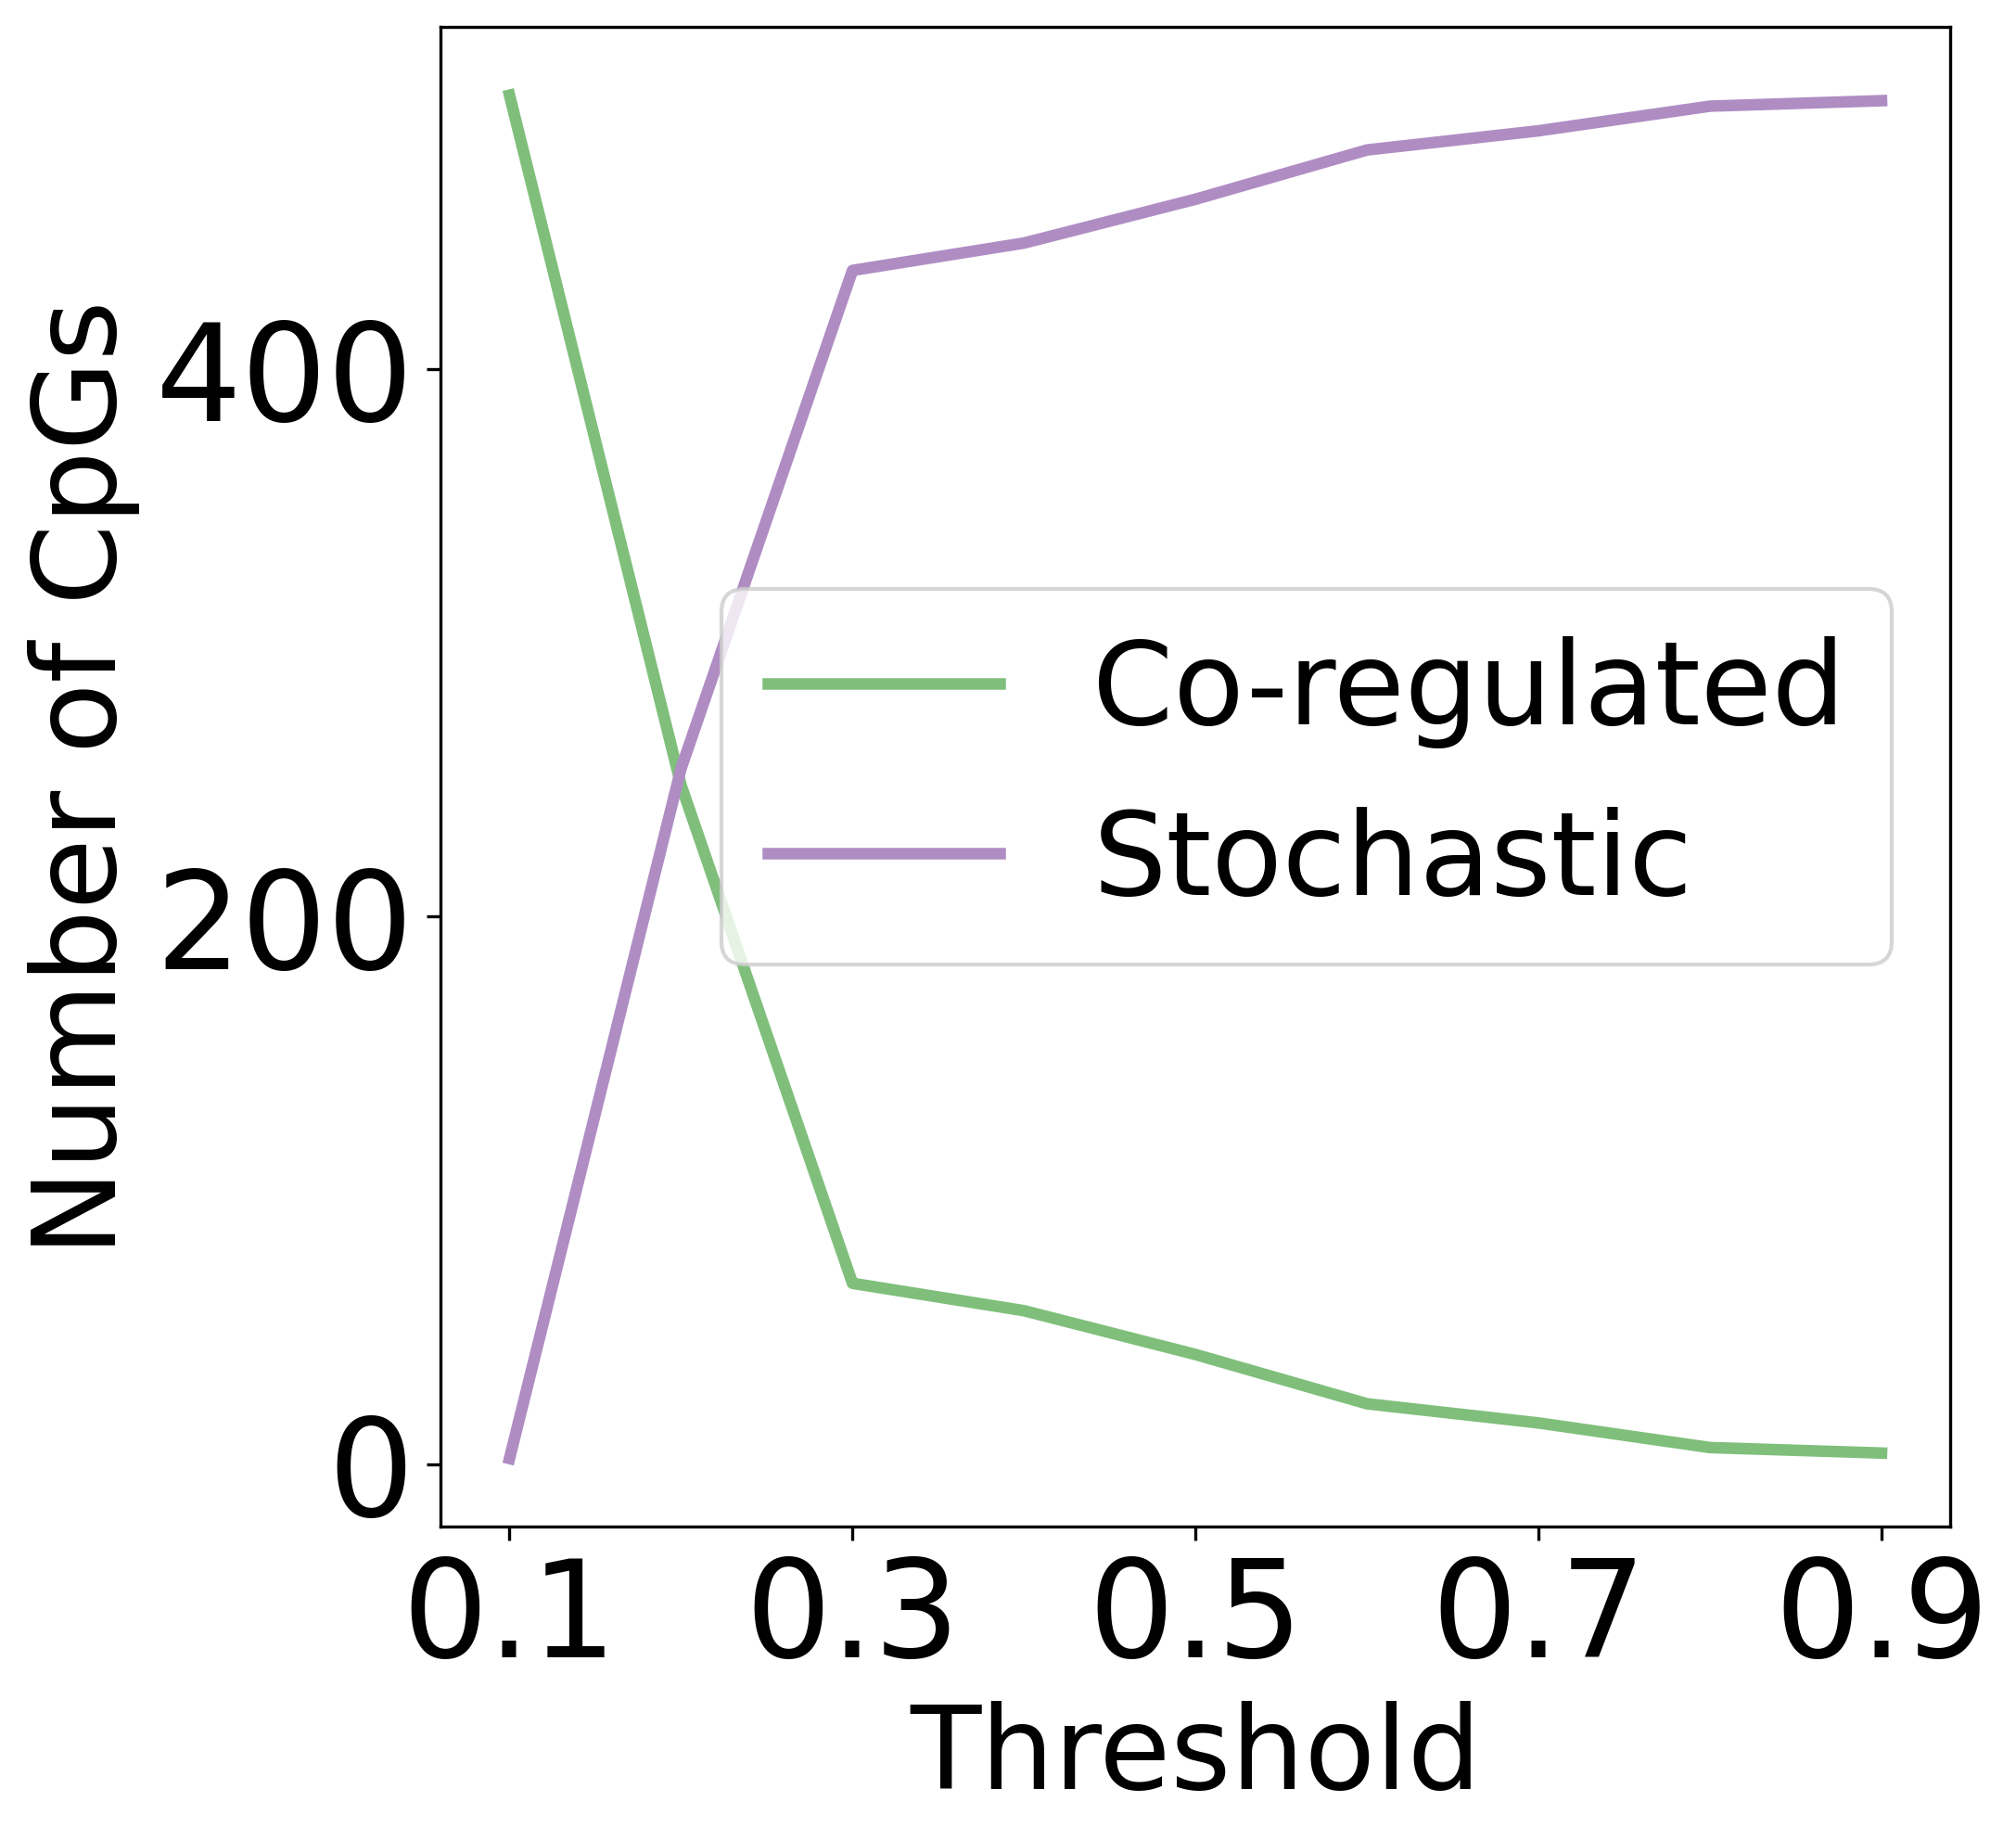

In [42]:

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('meth.mplstyle')
plt.figure(figsize=(7,7), dpi=300)
lab2name = {'coreg': 'Co-regulated',
            'stoch': 'Stochastic',
            'rand': 'Background'}
lab2color = {'coreg': '#7fbf7b',
            'stoch': '#af8dc3',
            'rand': '#999999'}
groups = ['coreg', 'stoch']
for group in groups:
    # try:
    if group == 'coreg':
        nums = numcoreg
    else:
        nums = 502 - np.array(numcoreg)
    plt.plot(corr_ths, nums, label=lab2name[group], 
                 color=lab2color[group], #lw=3,#capsize=5, 
        )
        # plt.fill_between(corr_ths, scores[group]['25%'], scores[group]['75%'], label=group, lw=1, alpha=0.3)
    # except:
    #     continue
plt.xlabel('Threshold')
plt.ylabel(f'Number of CpGs')
# if score == 'phyloP':
# plt.yticks([0.1, 0.2, 0.30, 0.4, 0.5])
plt.legend(loc='center right')

# elif score == 'phastCons':
#     plt.yticks([0.15, 0.20, 0.25])
#     plt.legend(loc='upper left')

# plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.savefig(f'PICS/Number_of_coreg_502.png', format='png', dpi=300)
plt.show()

# Plots for coreg and stoch and lowq

In [43]:
corr_th = 0.4
jdx_coreg = np.zeros(ag_corr.shape[0]) == 1
for i in trange(ag_corr.shape[0]):
    idx = np.abs(ag_corr[i,:]) > corr_th
    idx_old_cpg = np.abs(ag_corr_old[i,:]) > corr_th
    idx_you_cpg = np.abs(ag_corr_you[i,:]) > corr_th
    idx = np.logical_and(idx, idx_old_cpg)
    idx = np.logical_and(idx, idx_you_cpg)
    # if (np.sum(idx) > 1.5) and (np.sum(idx_you) > 1.5) and (np.sum(idx_old) > 1.5):
    if (np.sum(idx) > 1.5):
        jdx_coreg[idx] = True

100%|██████████| 502/502 [00:00<00:00, 57423.31it/s]


In [44]:
# np.sum(np.logical_and(jdx_coreg_entrs, jdx_coreg))
np.sum(jdx_coreg)

56

In [45]:
all_dsets.dsets_red[f'{key_sc}'].var.iloc[idx_sign].iloc[idx_sorted][~jdx_coreg].sort_index().to_csv('coreg_cpgs_v1.csv')

In [46]:
# 121/502, 381/502

In [47]:
idx_filter = jdx_coreg

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


['Y8', 'Y7', 'Y2', 'O5', 'O8', 'O1']
Categories (6, object): ['O1', 'O5', 'O8', 'Y2', 'Y7', 'Y8']
['Y2', 'Y7', 'Y8', 'O5', 'O1', 'O8']


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

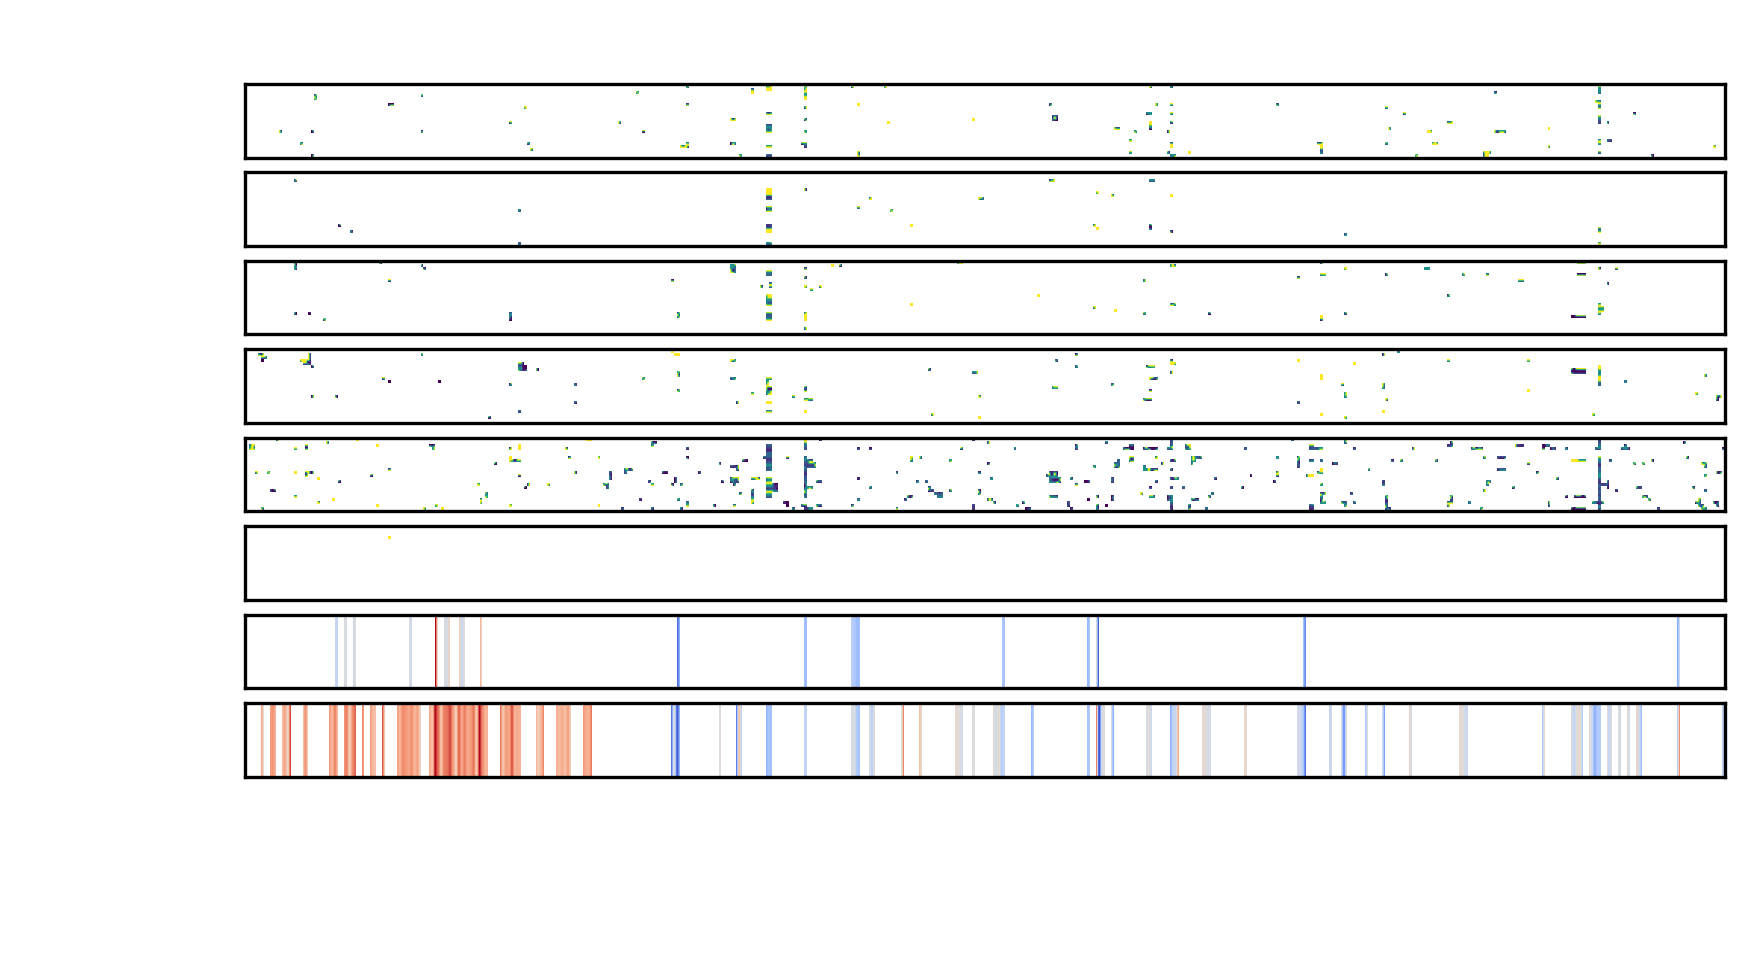

In [48]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['Y2', 'Y7', 'Y8', 'O5', 'O1', 'O8']
mice_young = ['Y2', 'Y7', 'Y8', 'O5']
print(mice)
fig, ax = plt.subplots(len(mice) + 2,1, figsize=(7,3),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse)
    
ax[-2].imshow(np.broadcast_to(lasco, (25,lasco.shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco, (25,ridco.shape[0])), cmap='coolwarm')

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]

plt.savefig(f'PICS/png/Th15_all_{direction}.png', format='png', dpi=300)
plt.show()

In [49]:
print('Lasso')
print(f'Lasso CpGs {np.sum(~np.isnan(lasco))}, All CpGs {lasco.shape}')
print(f'Lasso CoReg CpGs {np.sum(np.logical_and(~np.isnan(lasco), idx_filter))}, All CpGs {lasco.shape}, Coreg CpGs {np.sum(idx_filter)}')
print(f'Lasso Stoch CpGs {np.sum(np.logical_and(~np.isnan(lasco), ~idx_filter))}, All CpGs {lasco.shape}, Stoch CpGs {np.sum(~idx_filter)}')

print(7/102. * 100)
print(56/502. * 100)

print(95/102. * 100)
print(446/502. * 100)

print(f'ElNet CpGs {np.sum(~np.isnan(ridco))}, All CpGs{ridco.shape}')
print(f'ElNet CoReg CpGs {np.sum(np.logical_and(~np.isnan(ridco), idx_filter))}, All CpGs {ridco.shape}, Coreg CpGs {np.sum(idx_filter)}')
print(f'ElNet Stoch CpGs {np.sum(np.logical_and(~np.isnan(ridco), ~idx_filter))}, All CpGs {ridco.shape}, Stoch CpGs {np.sum(~idx_filter)}')


print(24/240. * 100)
print(56/502. * 100)

print(216/240. * 100)
print(446/502. * 100)

Lasso
Lasso CpGs 102, All CpGs (502,)
Lasso CoReg CpGs 7, All CpGs (502,), Coreg CpGs 56
Lasso Stoch CpGs 95, All CpGs (502,), Stoch CpGs 446
6.862745098039216
11.155378486055776
93.13725490196079
88.84462151394422
ElNet CpGs 240, All CpGs(502,)
ElNet CoReg CpGs 24, All CpGs (502,), Coreg CpGs 56
ElNet Stoch CpGs 216, All CpGs (502,), Stoch CpGs 446
10.0
11.155378486055776
90.0
88.84462151394422


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


['Y8', 'Y7', 'Y2', 'O5', 'O8', 'O1']
Categories (6, object): ['O1', 'O5', 'O8', 'Y2', 'Y7', 'Y8']
['Y2', 'Y7', 'Y8', 'O5', 'O1', 'O8']


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

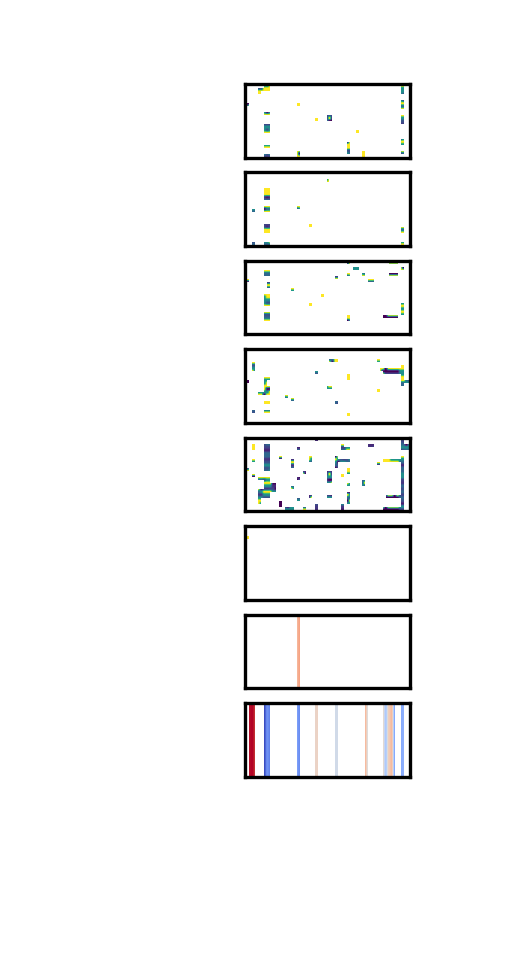

In [50]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['Y2', 'Y7', 'Y8', 'O5', 'O1', 'O8']
mice_young = ['Y2', 'Y7', 'Y8', 'O5']
print(mice)
fig, ax = plt.subplots(len(mice) + 2,1, figsize=(7,3),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter])
    
ax[-2].imshow(np.broadcast_to(lasco[idx_filter], (25,lasco[idx_filter].shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco[idx_filter], (25,ridco[idx_filter].shape[0])), cmap='coolwarm')

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]

plt.savefig(f'PICS/png/Th15_coreg_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


['Y8', 'Y7', 'Y2', 'O5', 'O8', 'O1']
Categories (6, object): ['O1', 'O5', 'O8', 'Y2', 'Y7', 'Y8']
['Y2', 'Y7', 'Y8', 'O5', 'O1', 'O8']


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

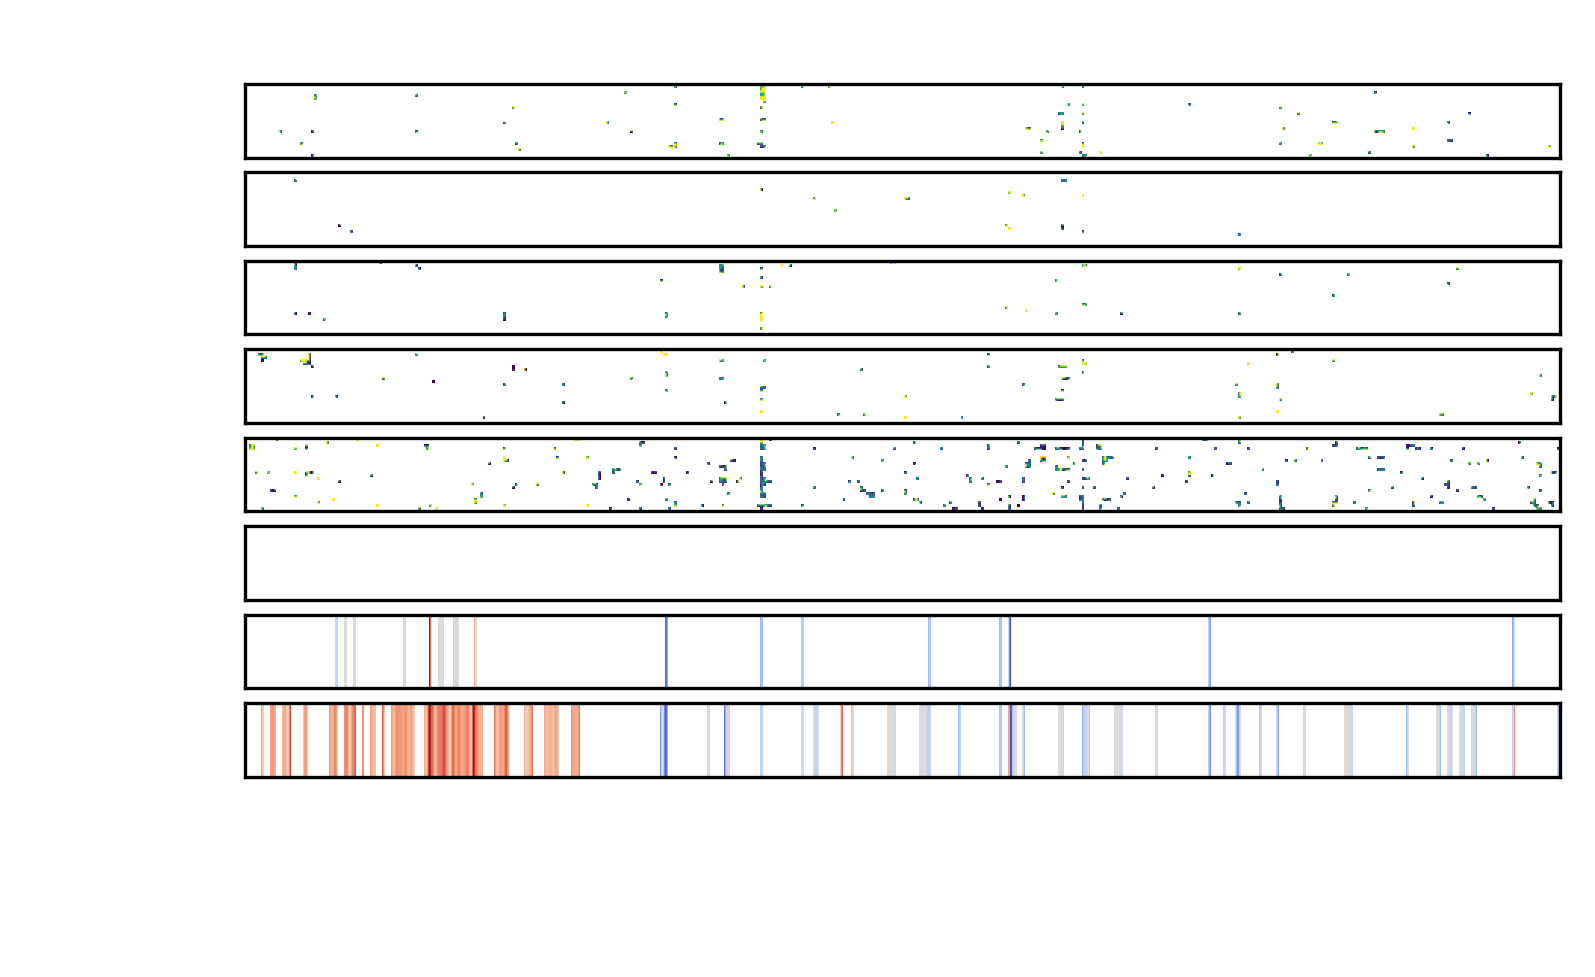

In [51]:
mice = params['Mouse_ID'].unique()
print(mice)
mice = ['Y2', 'Y7', 'Y8', 'O5', 'O1', 'O8']
mice_young = ['Y2', 'Y7', 'Y8', 'O5']
print(mice)
fig, ax = plt.subplots(len(mice) + 2,1, figsize=(7,3),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,~idx_filter])
    
ax[-2].imshow(np.broadcast_to(lasco[~idx_filter], (25,lasco[~idx_filter].shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco[~idx_filter], (25,ridco[~idx_filter].shape[0])), cmap='coolwarm')

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]

plt.savefig(f'PICS/png/Th15_stochastic_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

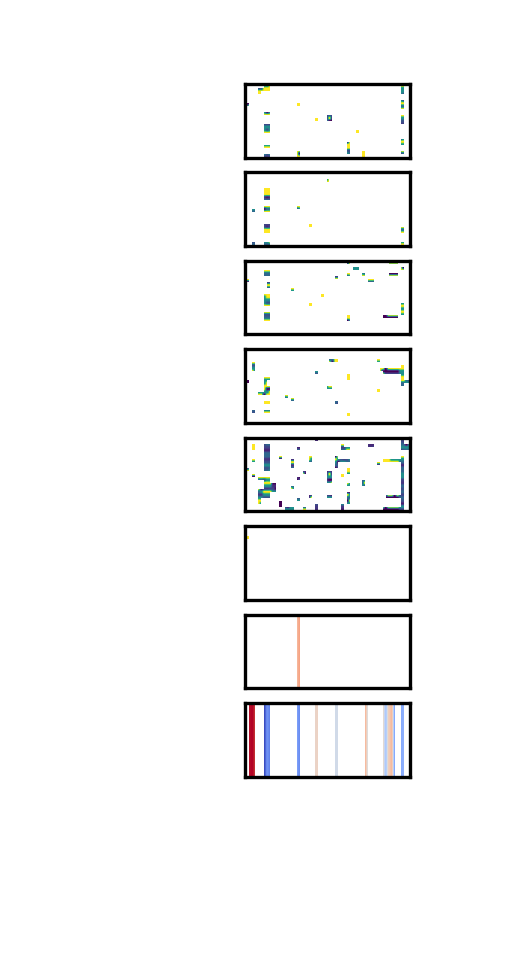

In [52]:
fig, ax = plt.subplots(len(mice) + 2,1,figsize=(7,3),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter])
    
ax[-2].imshow(np.broadcast_to(lasco[idx_filter], (25,lasco[idx_filter].shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco[idx_filter], (25,ridco[idx_filter].shape[0])), cmap='coolwarm')

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_coreg_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

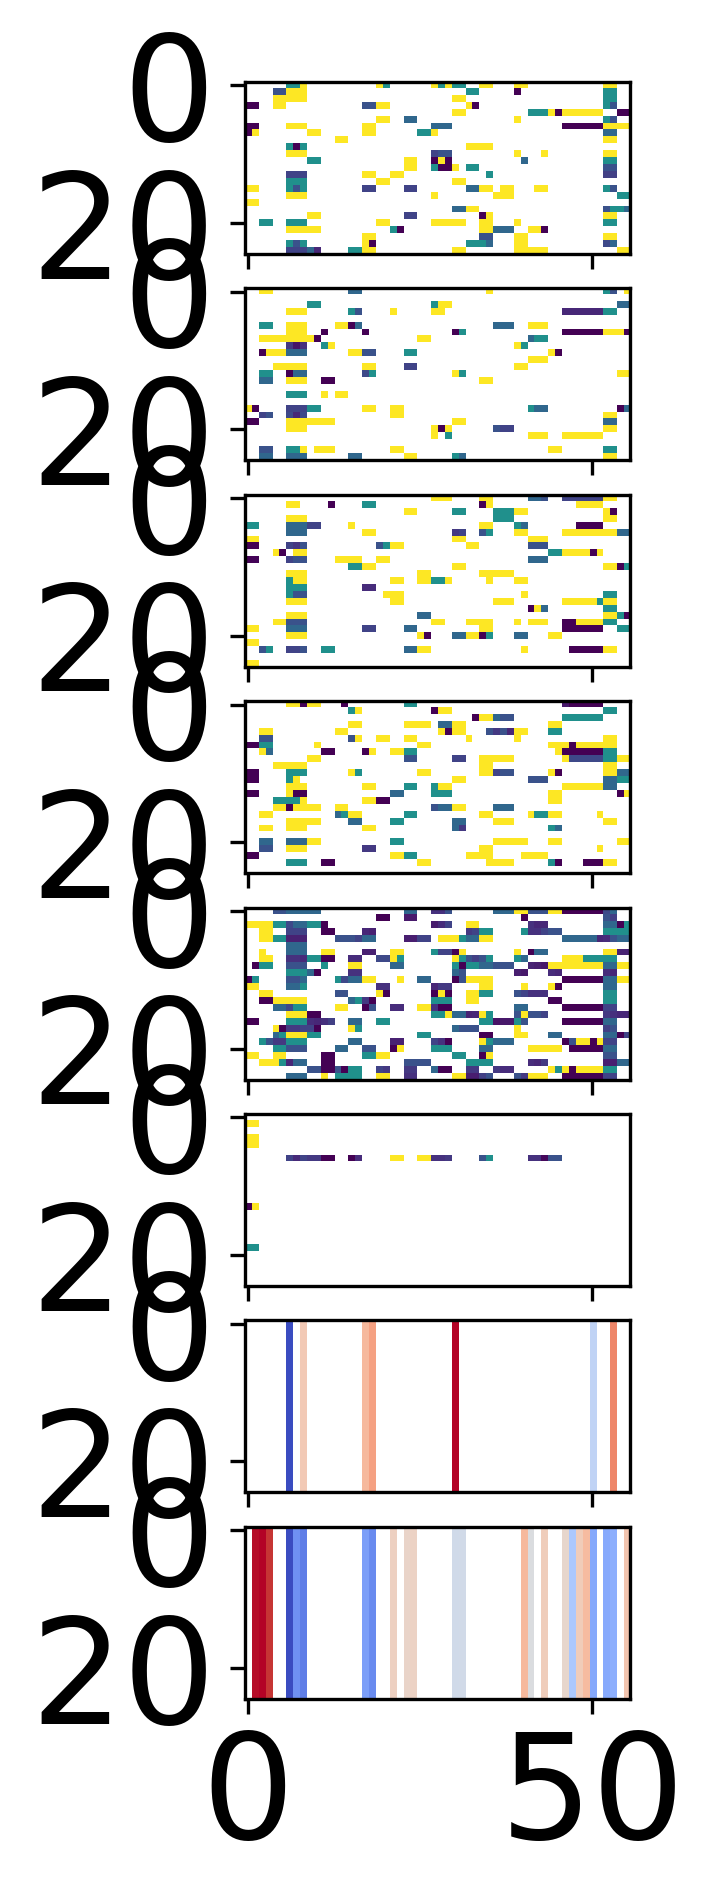

In [53]:
fig, ax = plt.subplots(len(mice) + 2,1, figsize=(7,7),dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:].copy()
    ax[i].imshow(xmouse[:,idx_filter])
    
ax[-2].imshow(np.broadcast_to(lasco[idx_filter], (25,lasco[idx_filter].shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco[idx_filter], (25,ridco[idx_filter].shape[0])), cmap='coolwarm')
plt.savefig(f'PICS/Th15_coreg_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

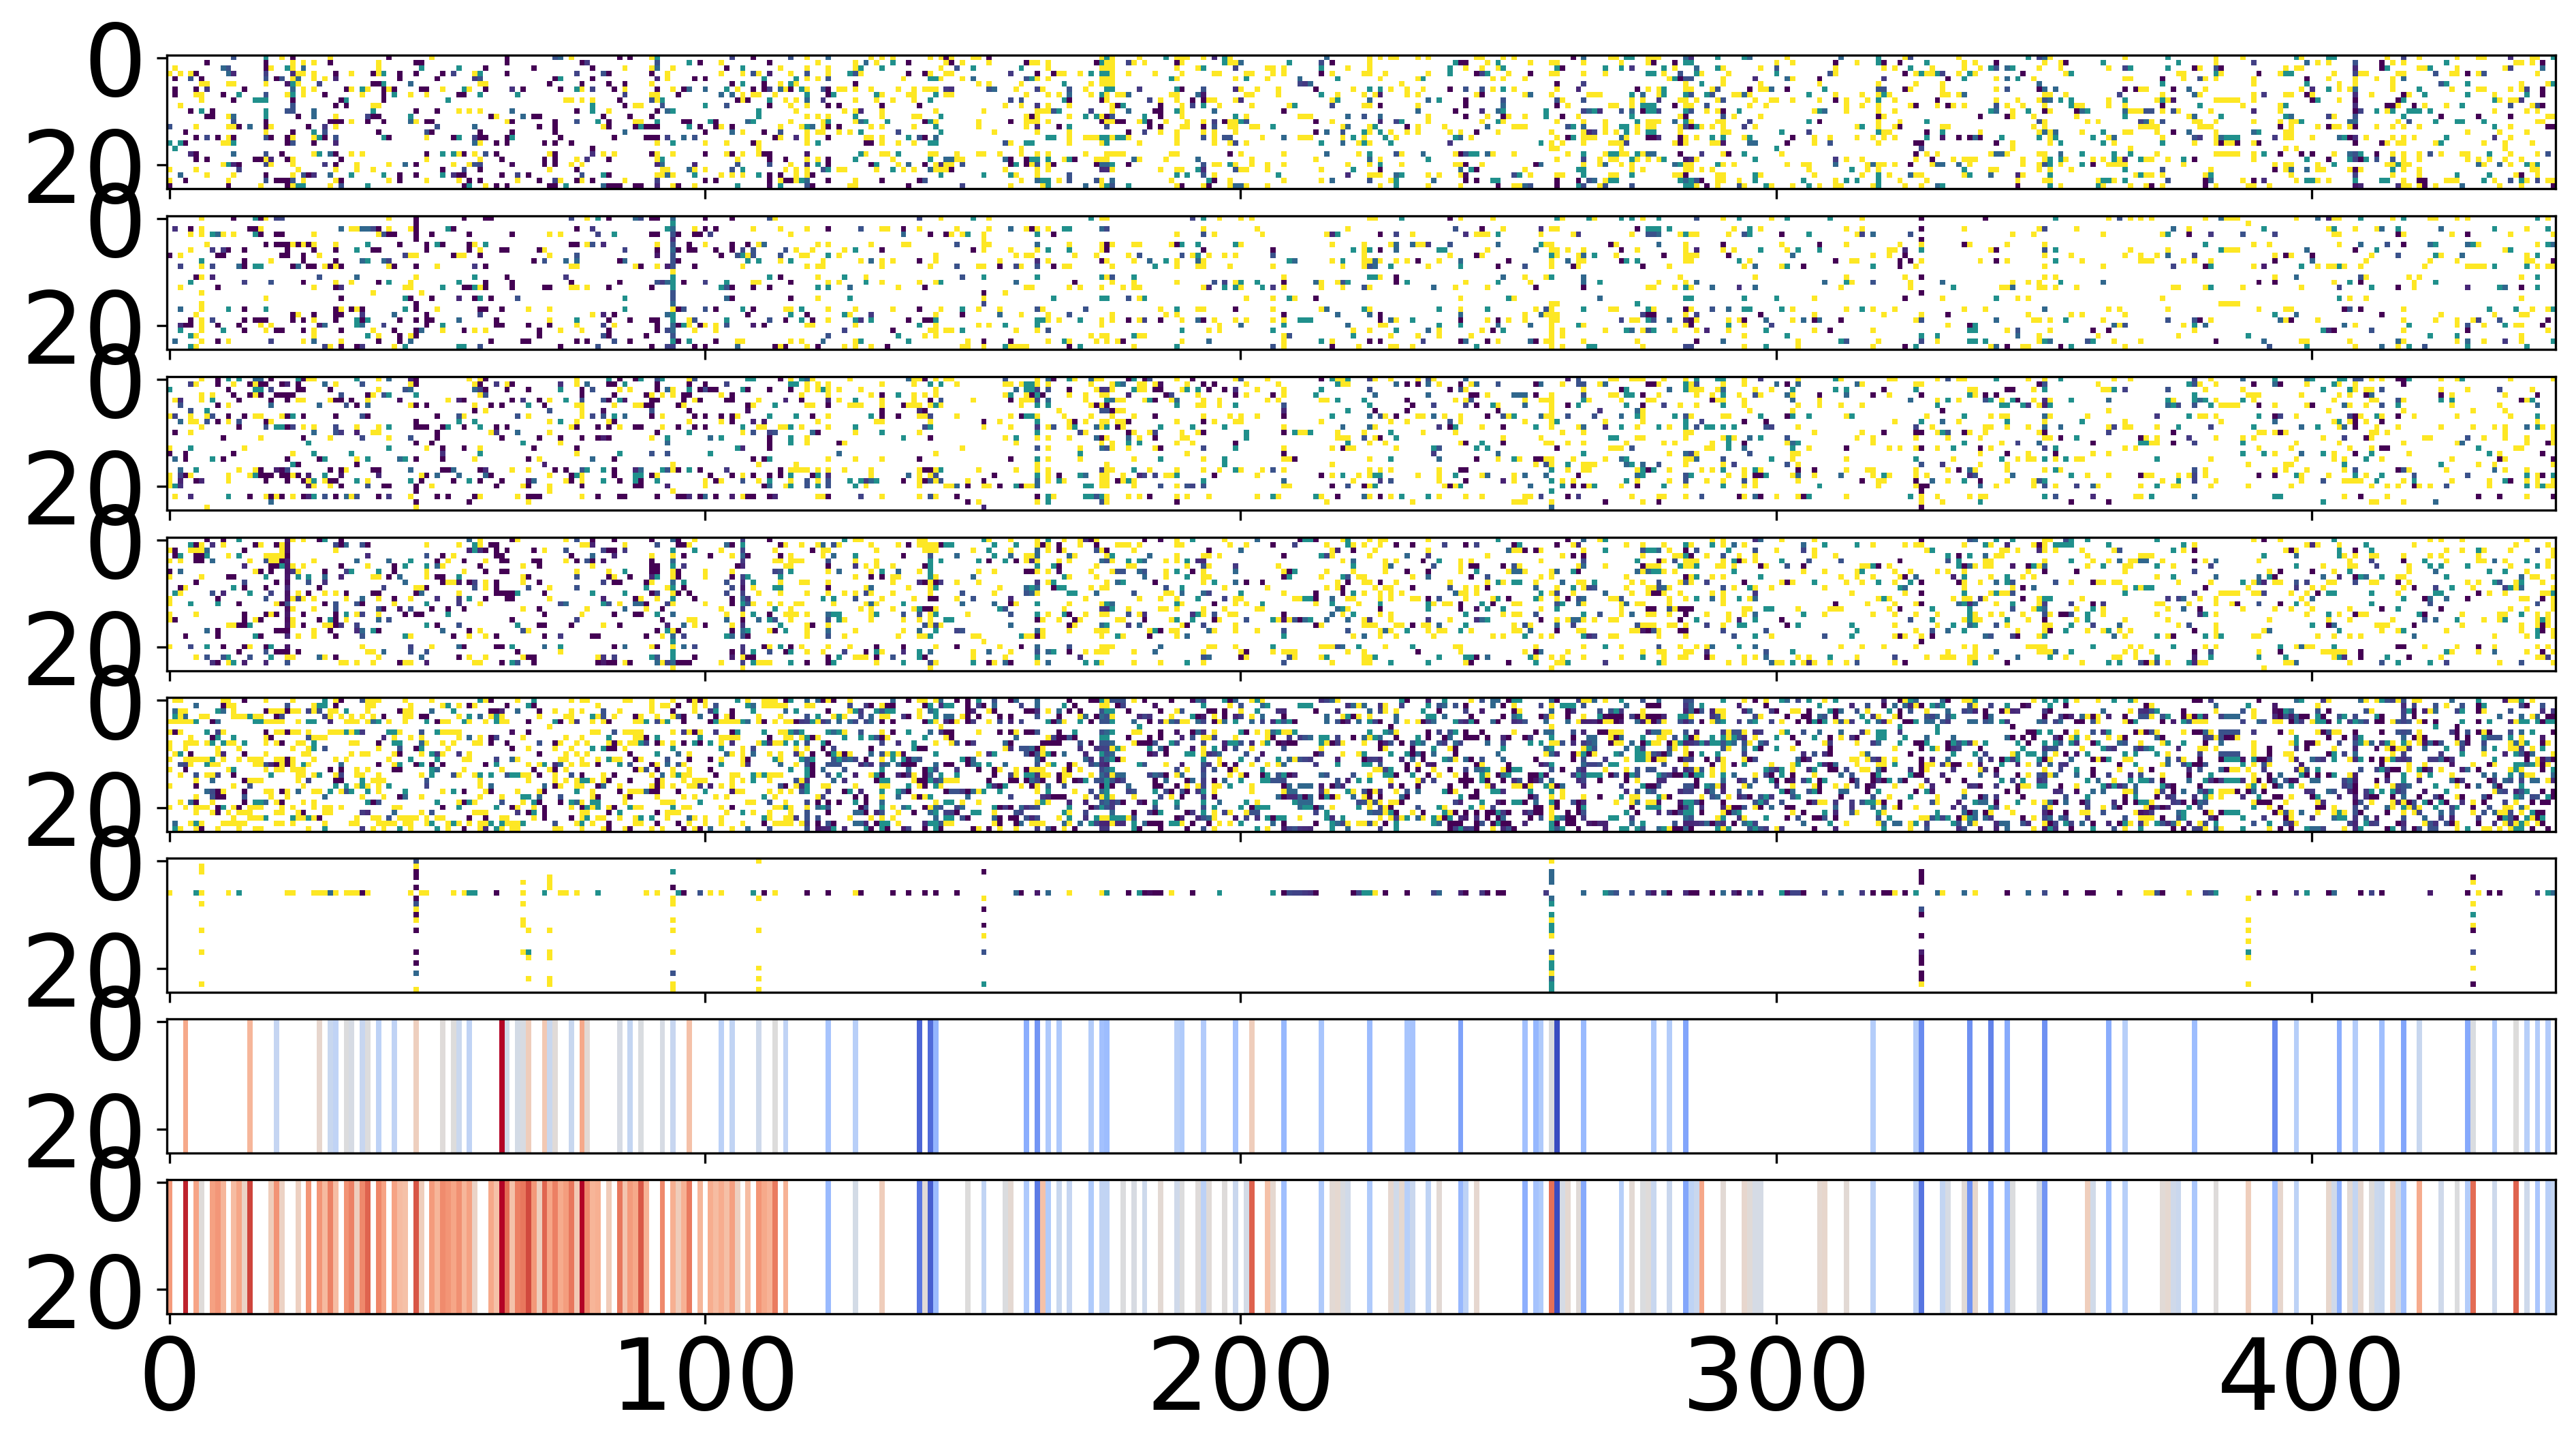

In [54]:
fig, ax = plt.subplots(len(mice) + 2,1, figsize=figsize_for[direction],dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,~idx_filter])
    
ax[-2].imshow(np.broadcast_to(lasco[~idx_filter], (25,lasco[~idx_filter].shape[0])),cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco[~idx_filter], (25,ridco[~idx_filter].shape[0])),cmap='coolwarm')

plt.savefig(f'PICS/Th15_stochastic_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

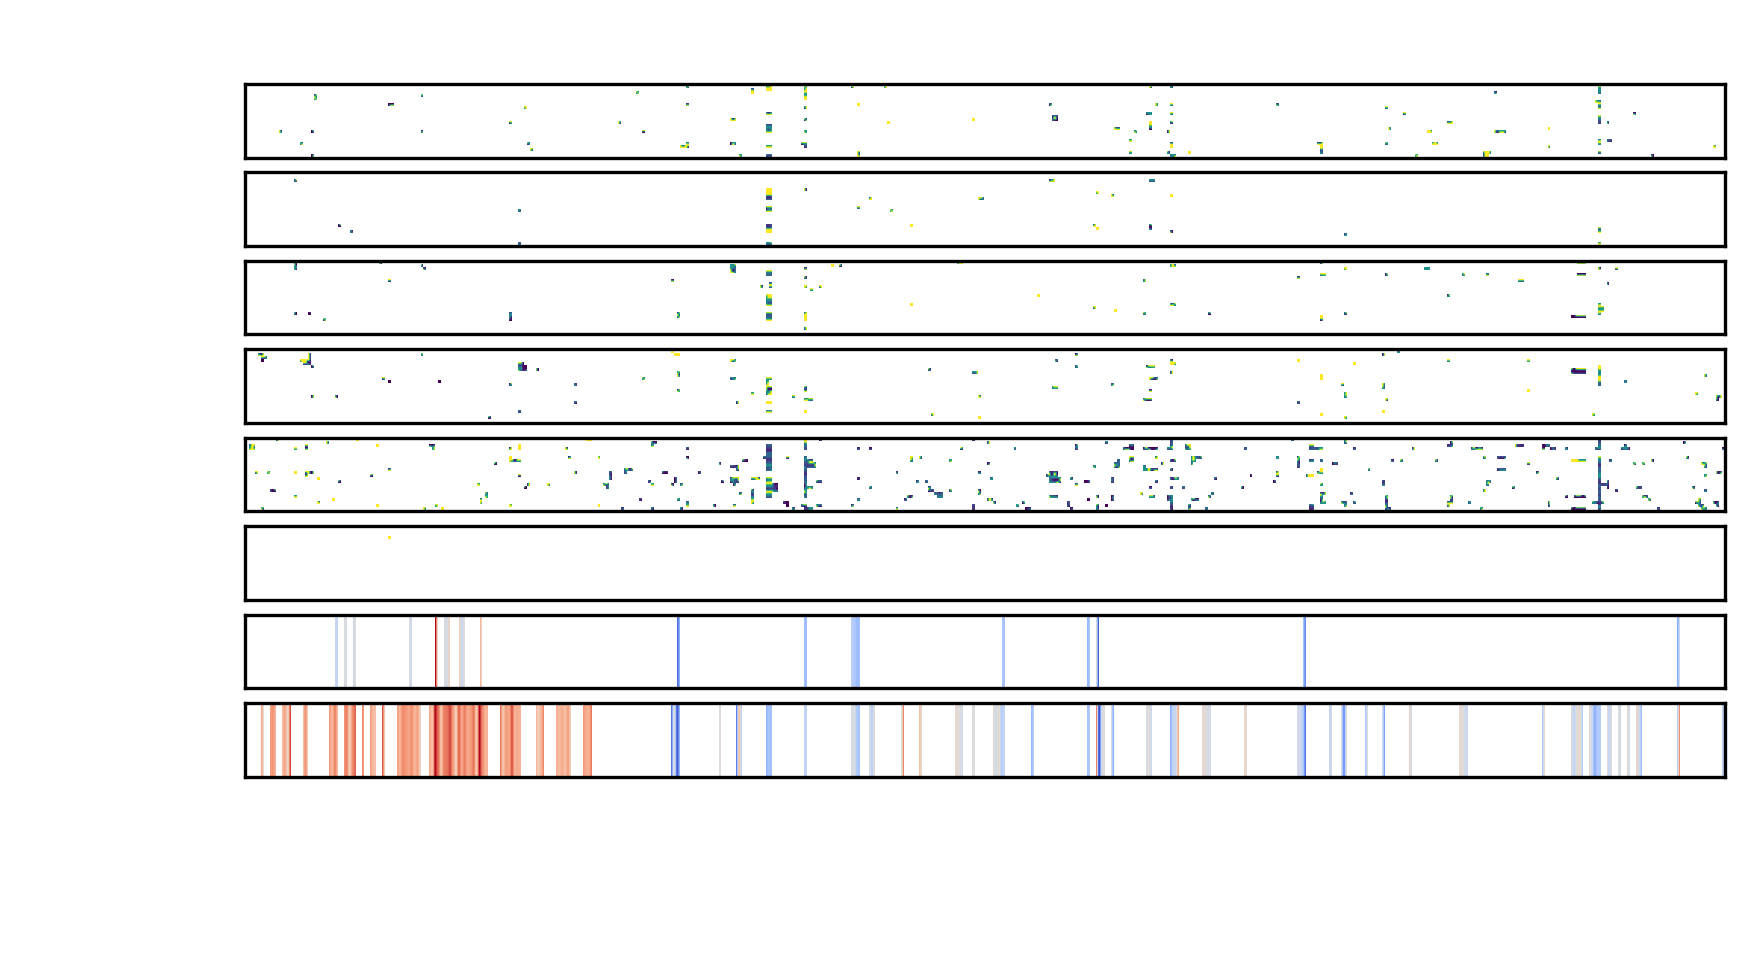

In [55]:
fig, ax = plt.subplots(len(mice) + 2,1, figsize=(7,3),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse)
    
ax[-2].imshow(np.broadcast_to(lasco, (25,lasco.shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco, (25,ridco.shape[0])), cmap='coolwarm')

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_full_{direction}.png', format='png', dpi=300)
plt.show()

In [56]:
idx_filter_cut = idx_filter.copy()
for i in range(-5, 5):
    idx_filter_cut[np.roll(idx_filter,i)] = True
# idx_filter_cut[np.roll(idx_filter,1)] = True
# idx_filter_cut[np.roll(idx_filter,-1)] = True

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

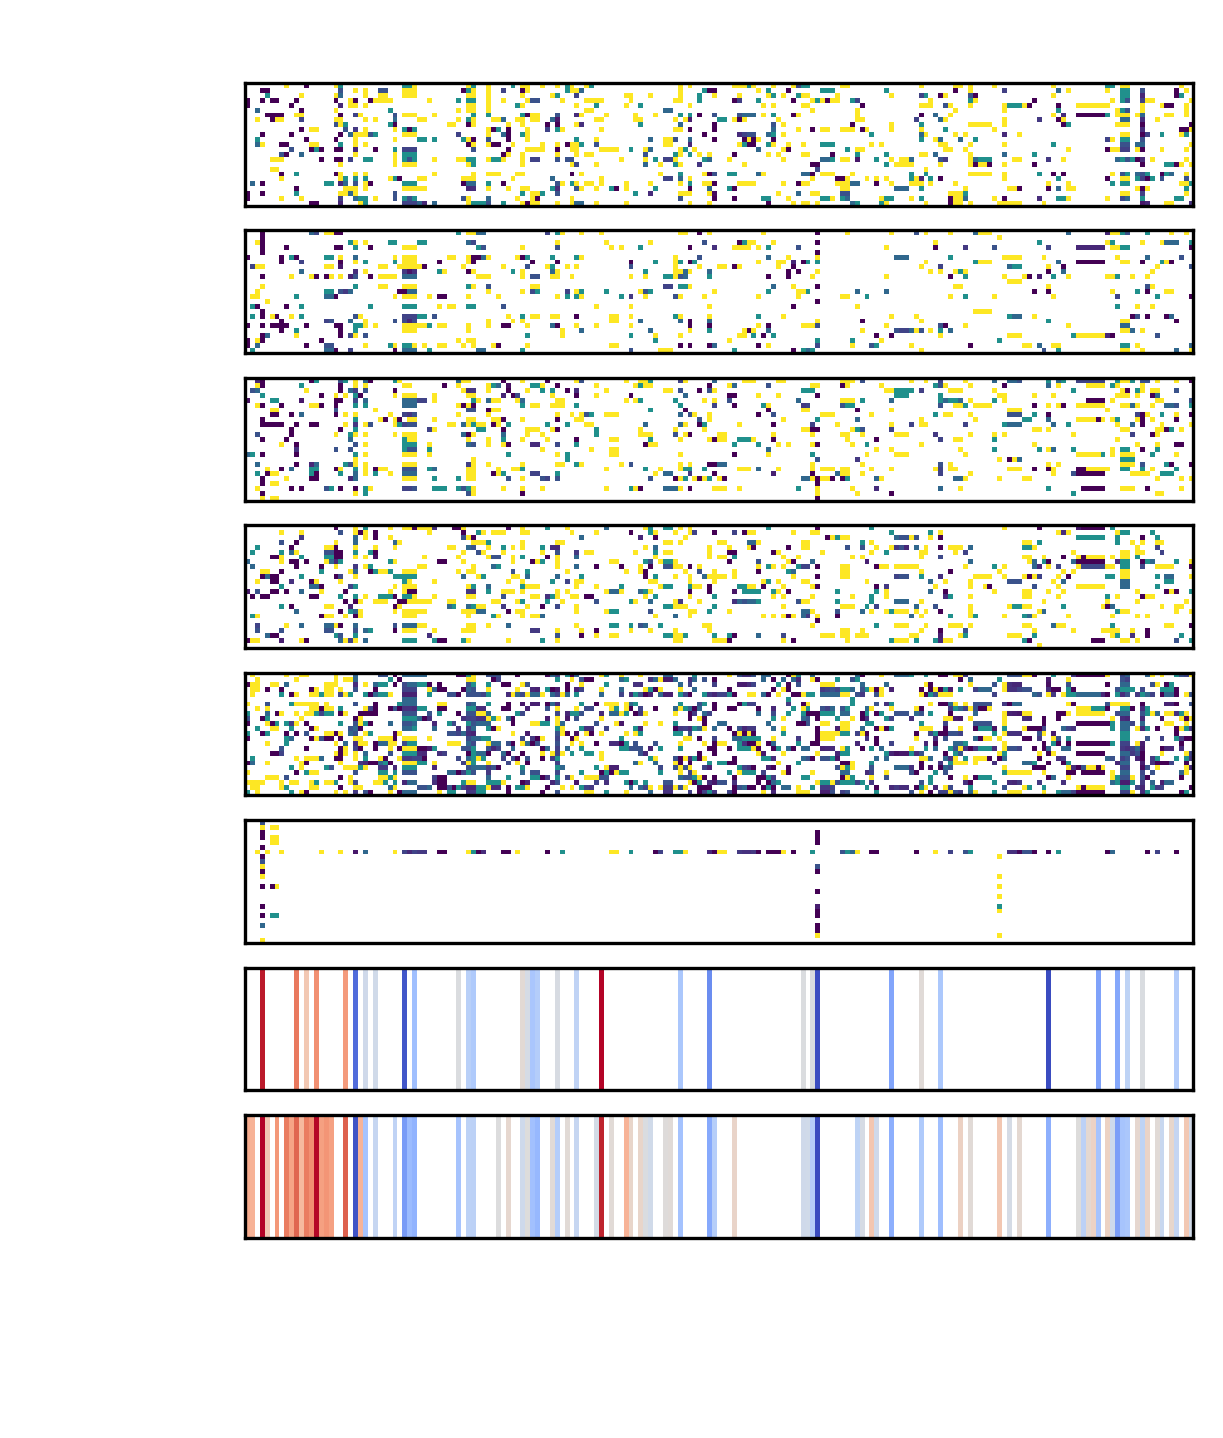

In [57]:
fig, ax = plt.subplots(len(mice) + 2,1,figsize=(7,5),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter_cut])
    
ax[-2].imshow(np.broadcast_to(lasco[idx_filter_cut], (25,lasco[idx_filter_cut].shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco[idx_filter_cut], (25,ridco[idx_filter_cut].shape[0])), cmap='coolwarm')

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_coreg_stochastic_cut_{direction}.png', format='png', dpi=300)
plt.show()

# Fig. 4b

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

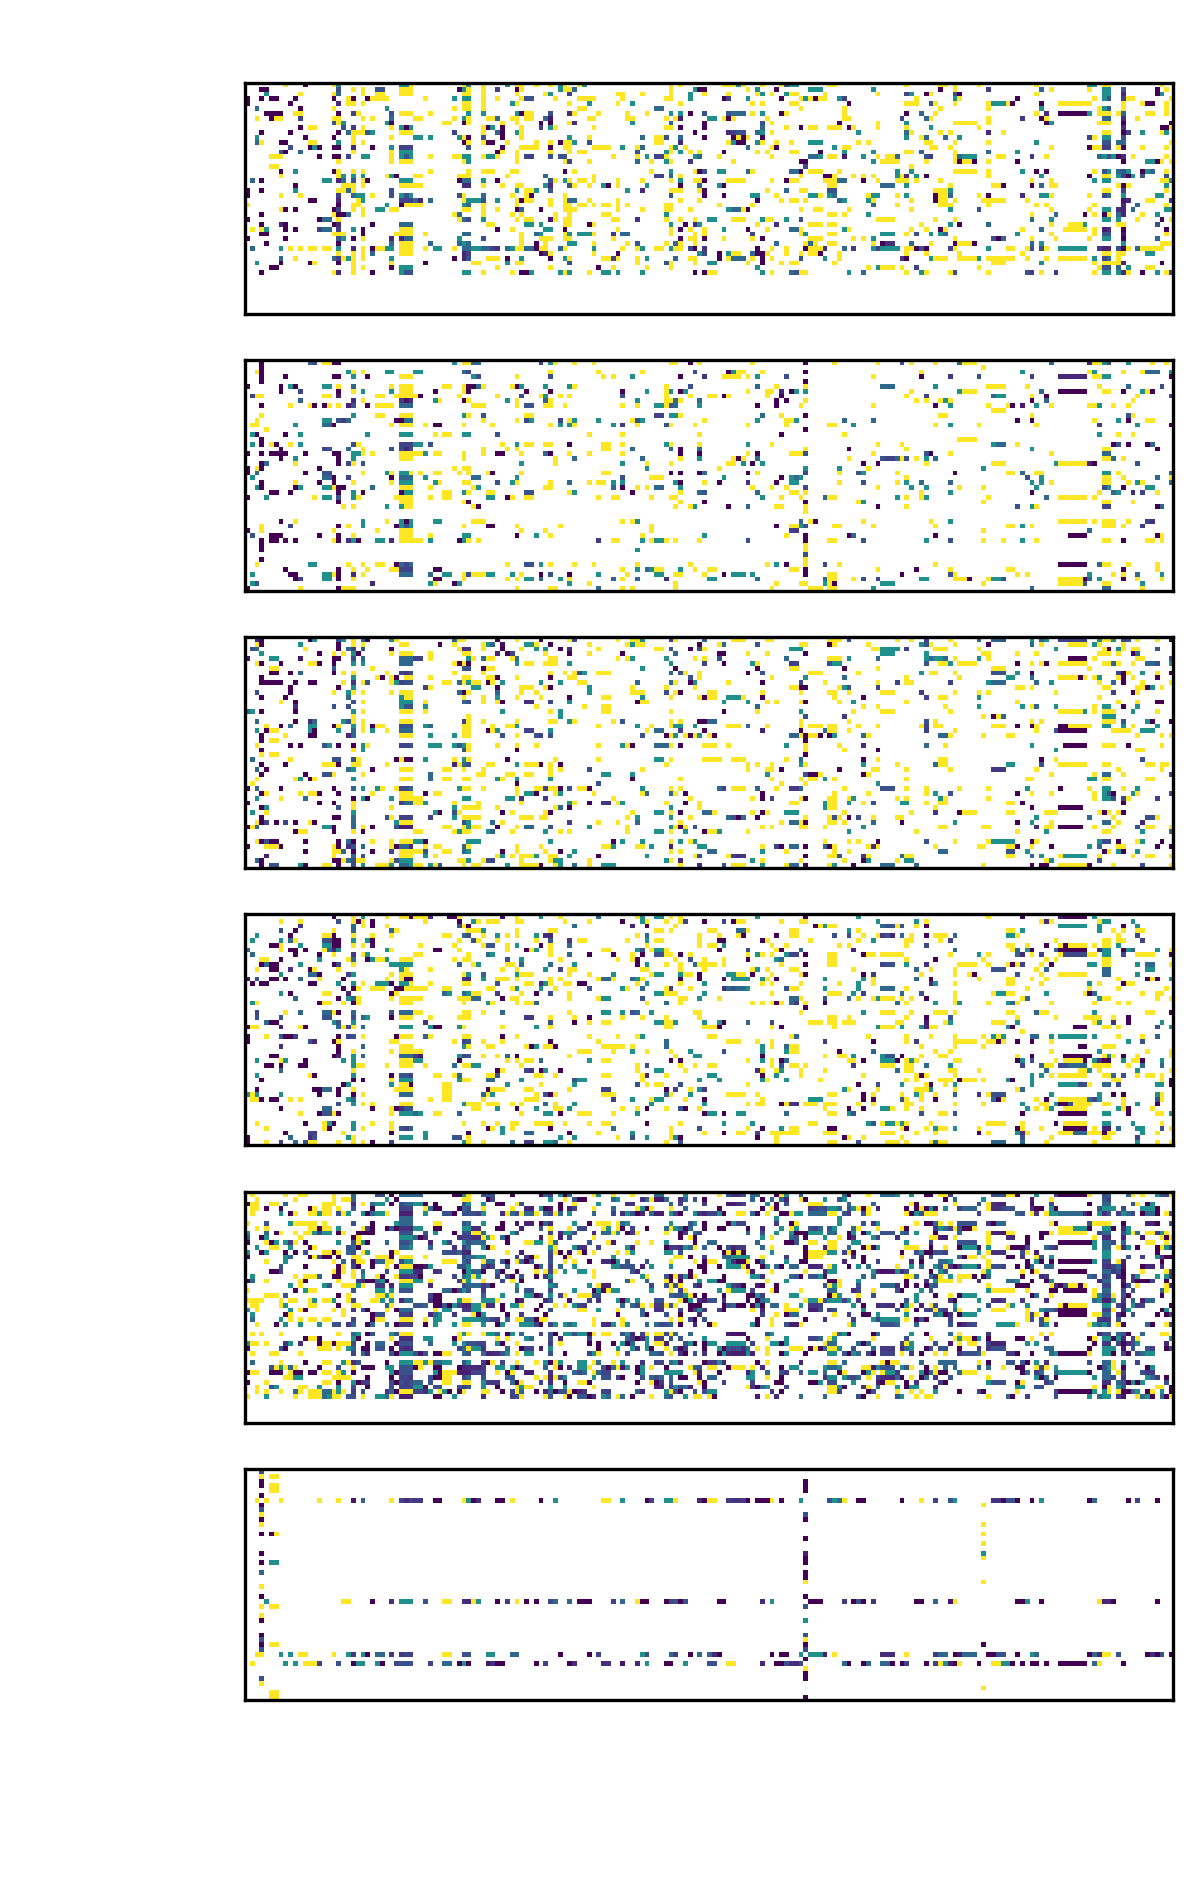

In [58]:
fig, ax = plt.subplots(len(mice),1,figsize=(7,7),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter_cut])

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_coreg_stochastic_cut_no_lasso_{direction}.png', format='png', dpi=300)
plt.show()

In [59]:
idx_filter_stoch = np.logical_and(idx_filter_cut, ~idx_filter)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

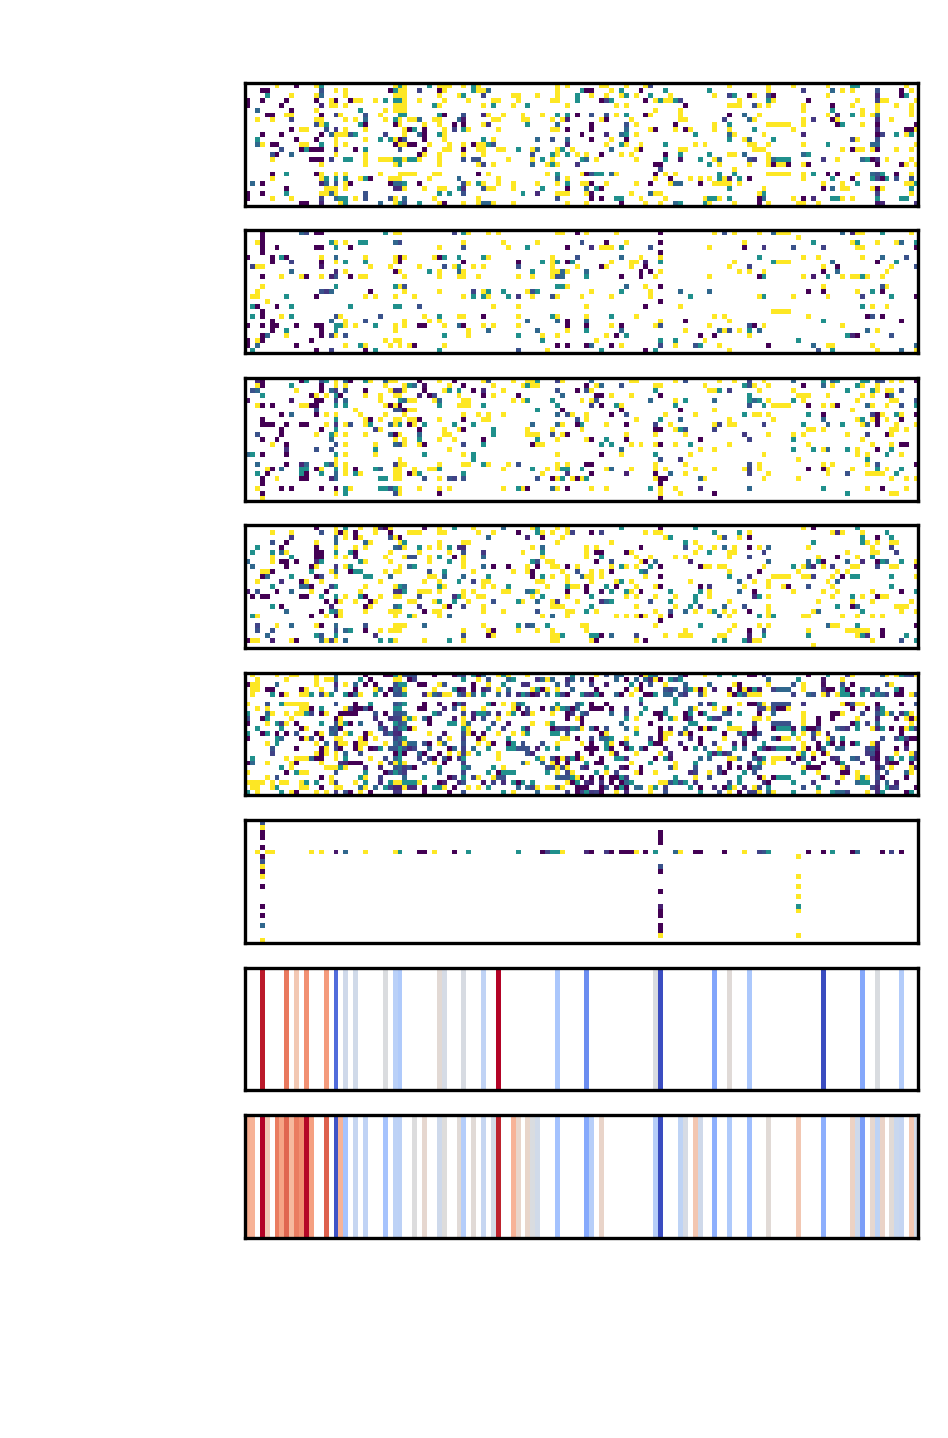

In [60]:
fig, ax = plt.subplots(len(mice) + 2,1, figsize=(7,5),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter_stoch])
    
ax[-2].imshow(np.broadcast_to(lasco[idx_filter_stoch], (25,lasco[idx_filter_stoch].shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco[idx_filter_stoch], (25,ridco[idx_filter_stoch].shape[0])), cmap='coolwarm')

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_stochastic_cut_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

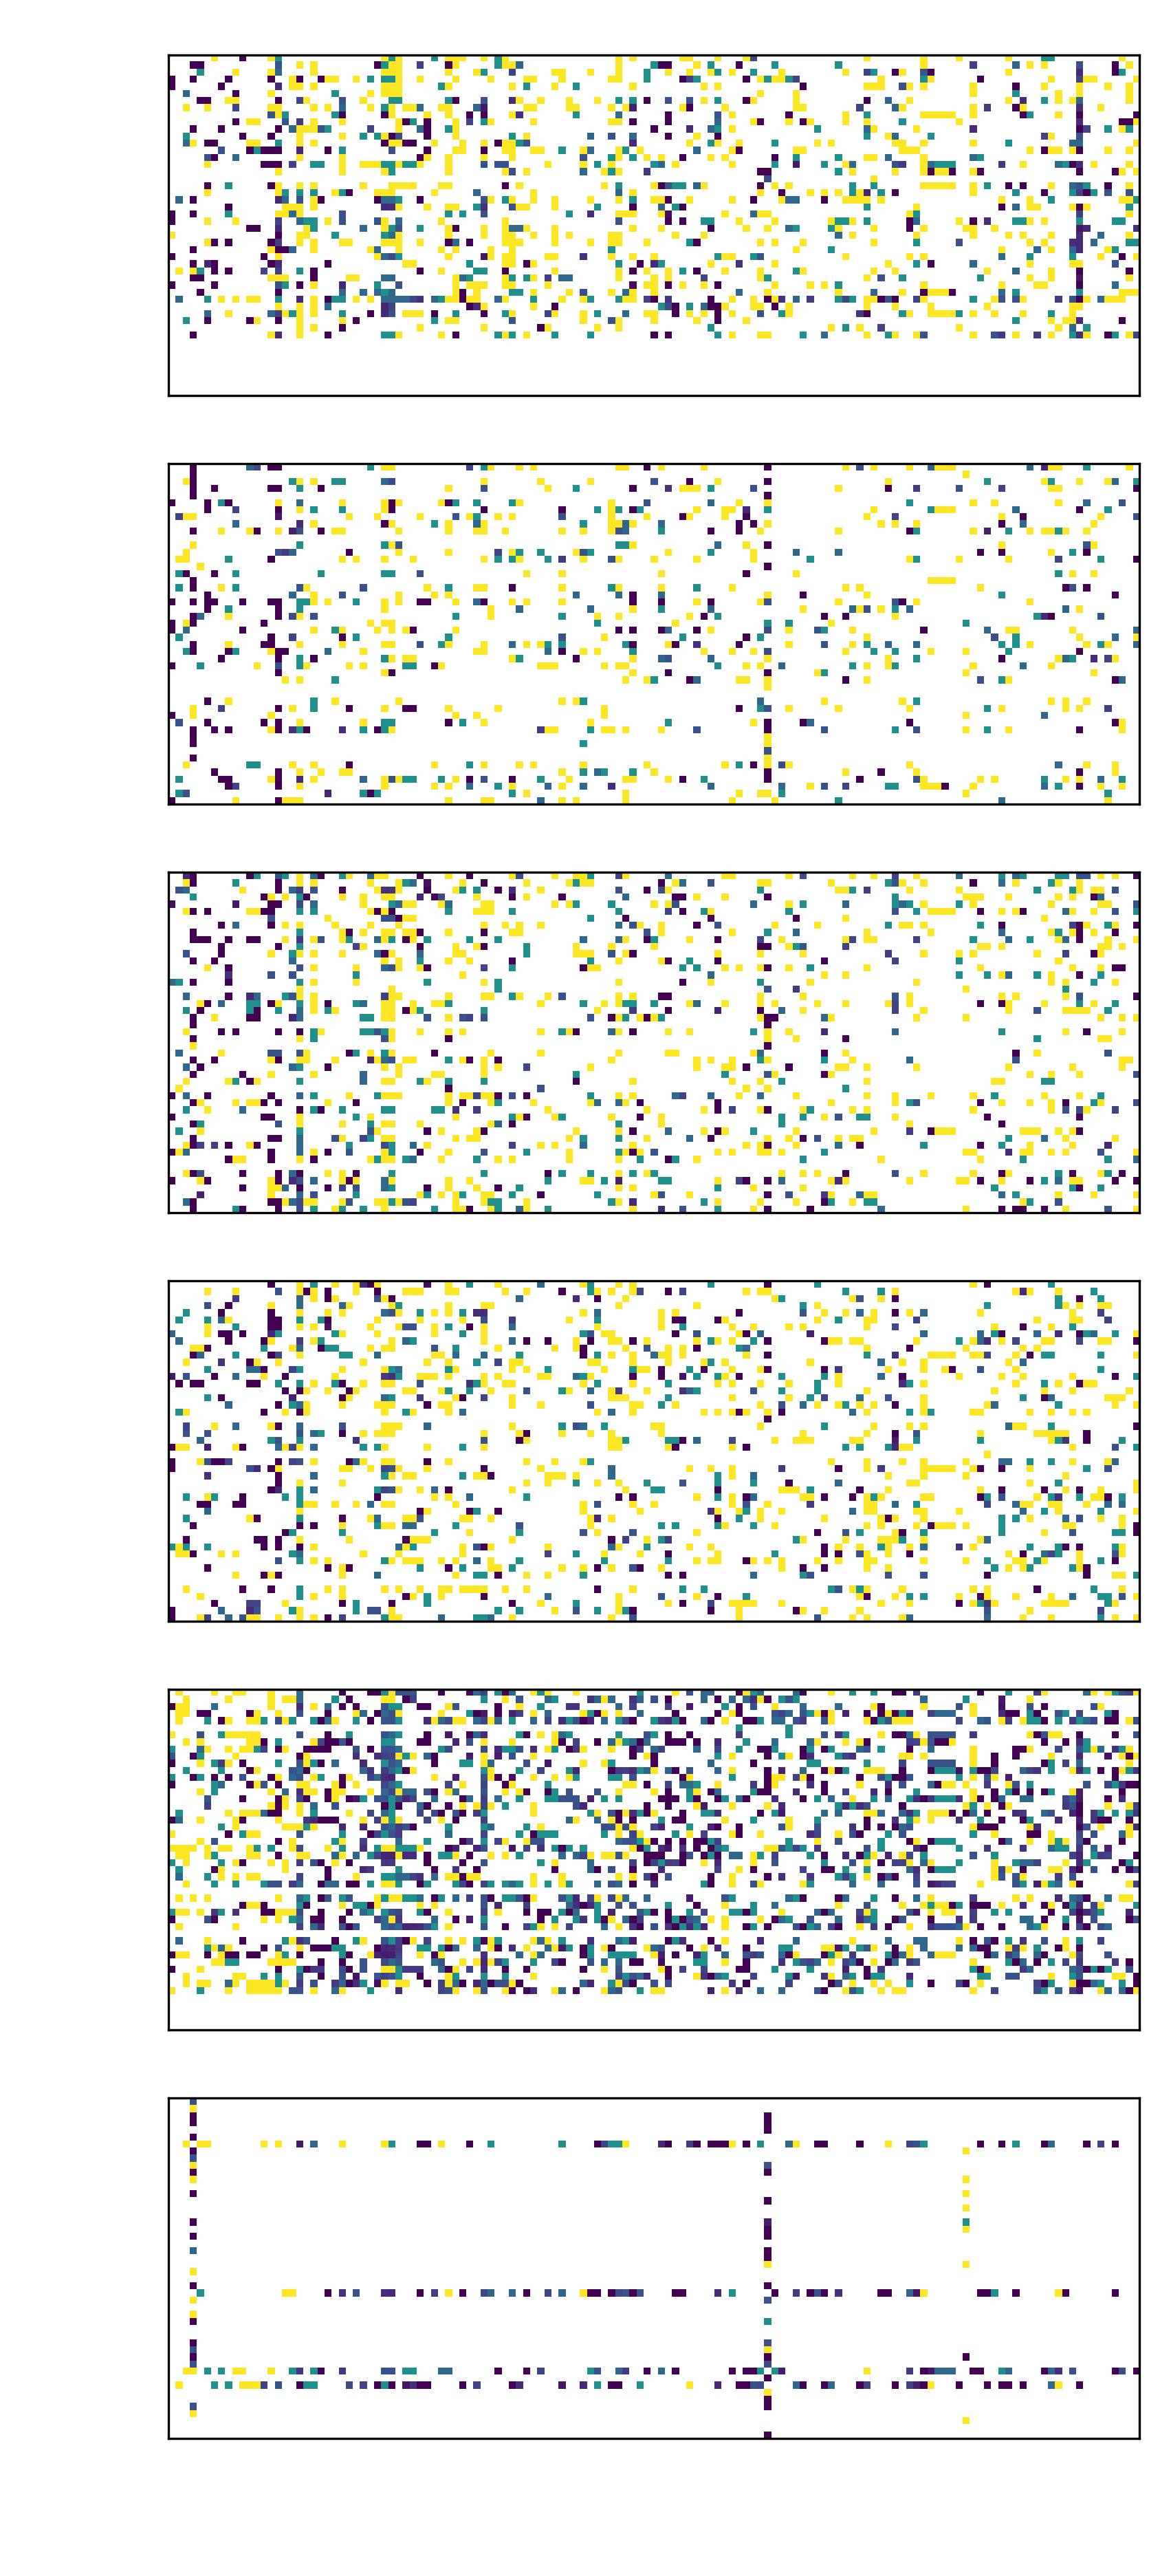

In [61]:
fig, ax = plt.subplots(len(mice),1, figsize=(7,15),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter_stoch])
    
[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_stochastic_cut_no_lasso_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

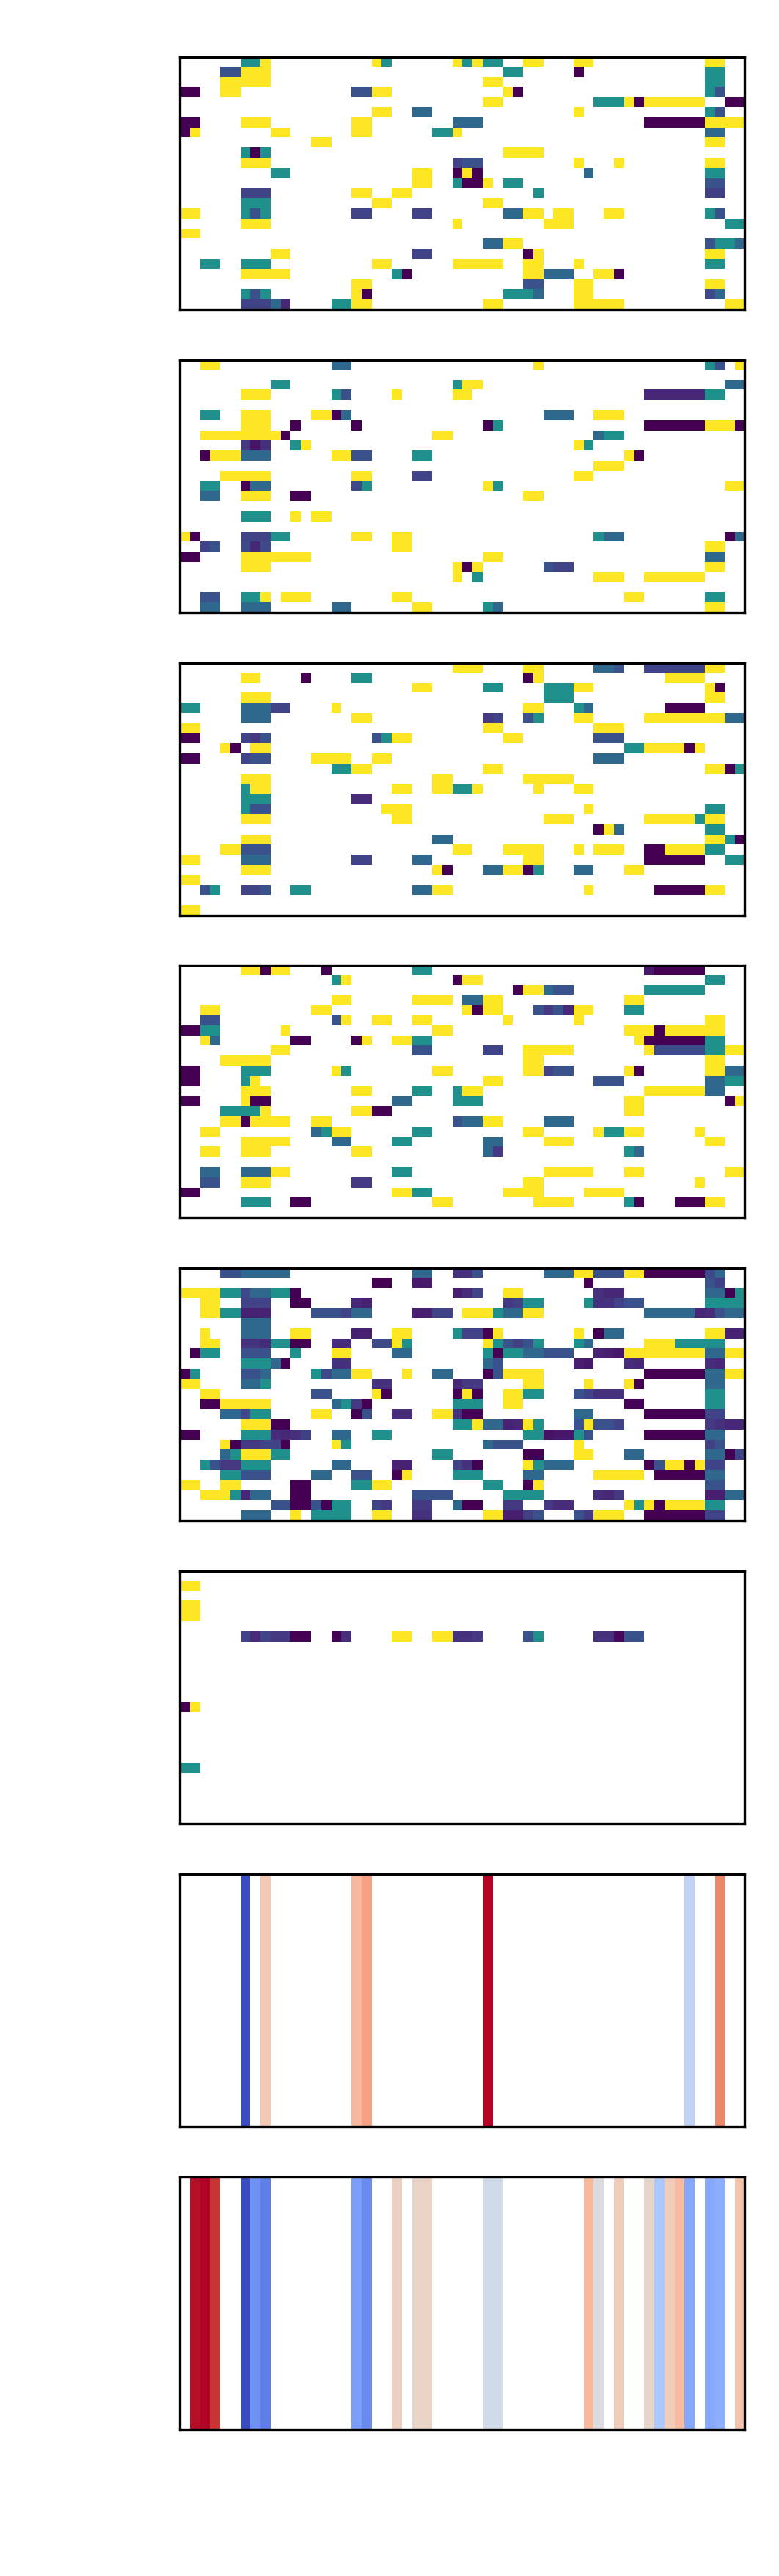

In [62]:
fig, ax = plt.subplots(len(mice) + 2,1,figsize=(7,14),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter])
    
ax[-2].imshow(np.broadcast_to(lasco[idx_filter], (25,lasco[idx_filter].shape[0])), cmap='coolwarm')
ax[-1].imshow(np.broadcast_to(ridco[idx_filter], (25,ridco[idx_filter].shape[0])), cmap='coolwarm')

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]

plt.savefig(f'PICS/png/Th15_coreg_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

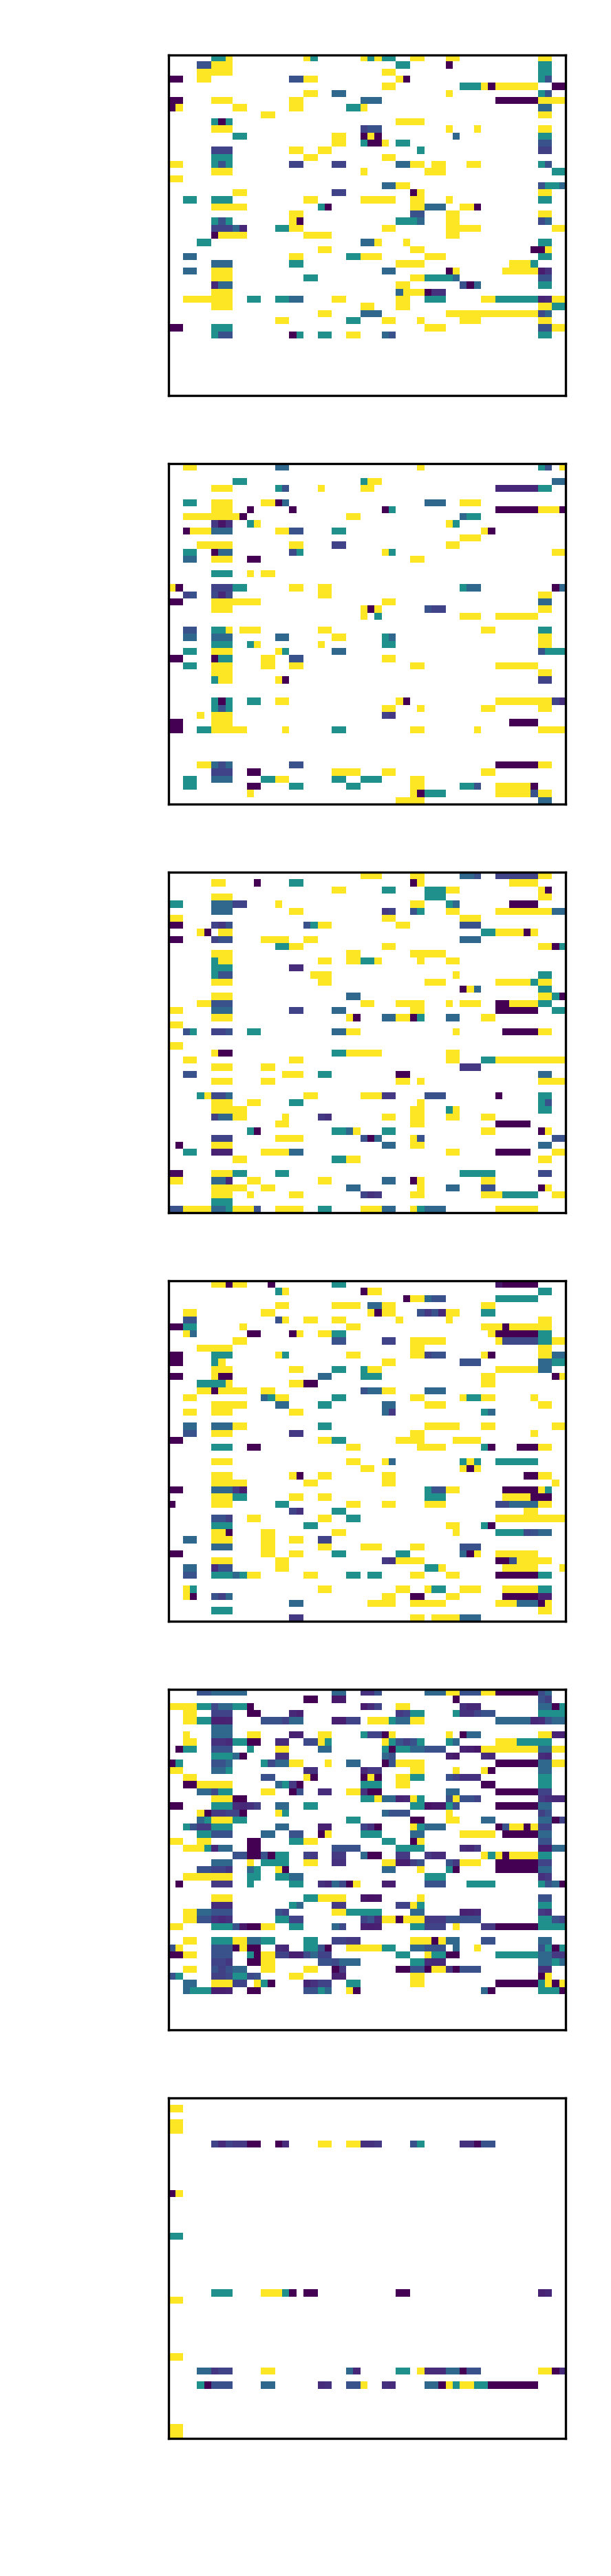

In [63]:
fig, ax = plt.subplots(len(mice),1,figsize=(7,15),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter])
    
[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_coreg_no_lasso_{direction}.png', format='png', dpi=300)
plt.show()

# Fig. 4c

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

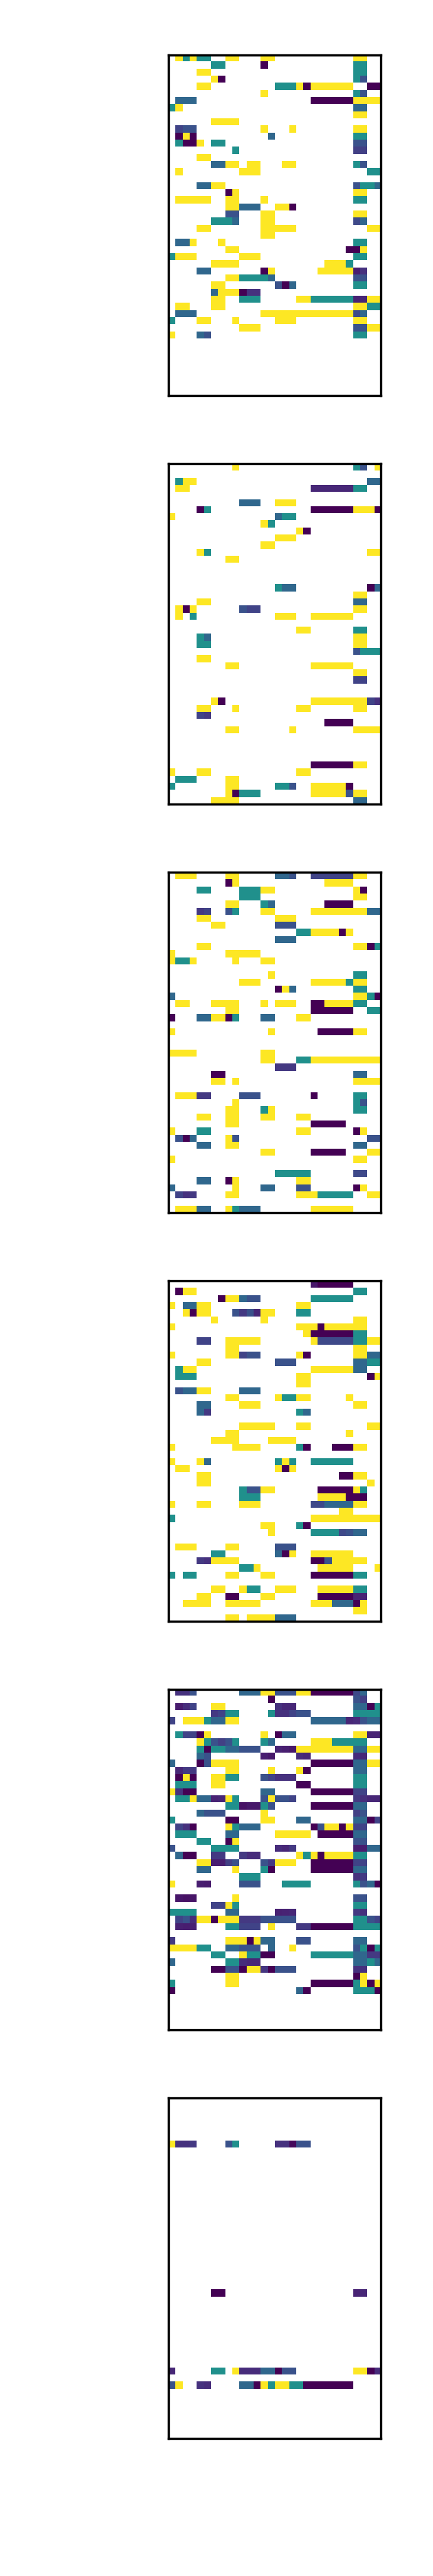

In [64]:
fig, ax = plt.subplots(len(mice),1,figsize=(7,15),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter][:,-30:])

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_coreg_no_lasso_zoom_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


(40, 502)
(48, 502)
(48, 502)
(48, 502)
(43, 502)
(48, 502)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

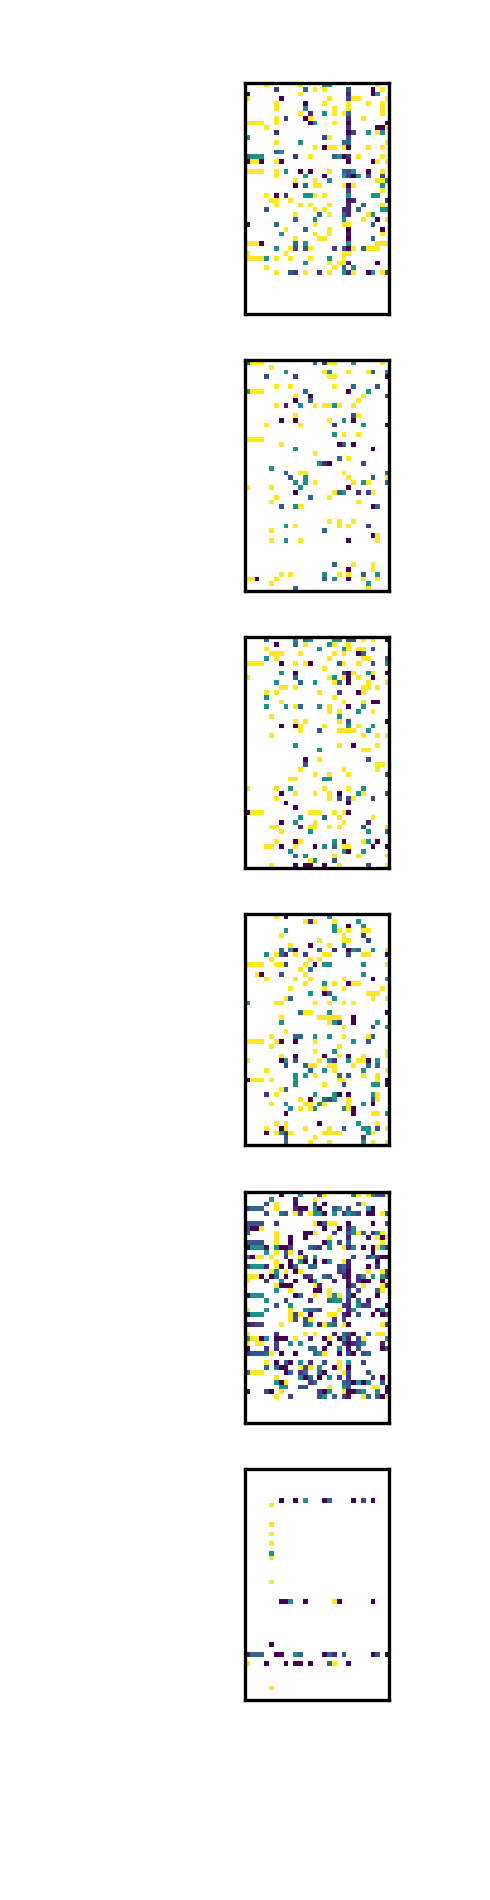

In [65]:
fig, ax = plt.subplots(len(mice),1, figsize=(1,7),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    print(xmouse.shape)
    ax[i].imshow(xmouse[:,idx_filter_stoch][:,-30:])
    
[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_stochastic_cut_no_lasso_zoom_{direction}.png', format='png', dpi=300)
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

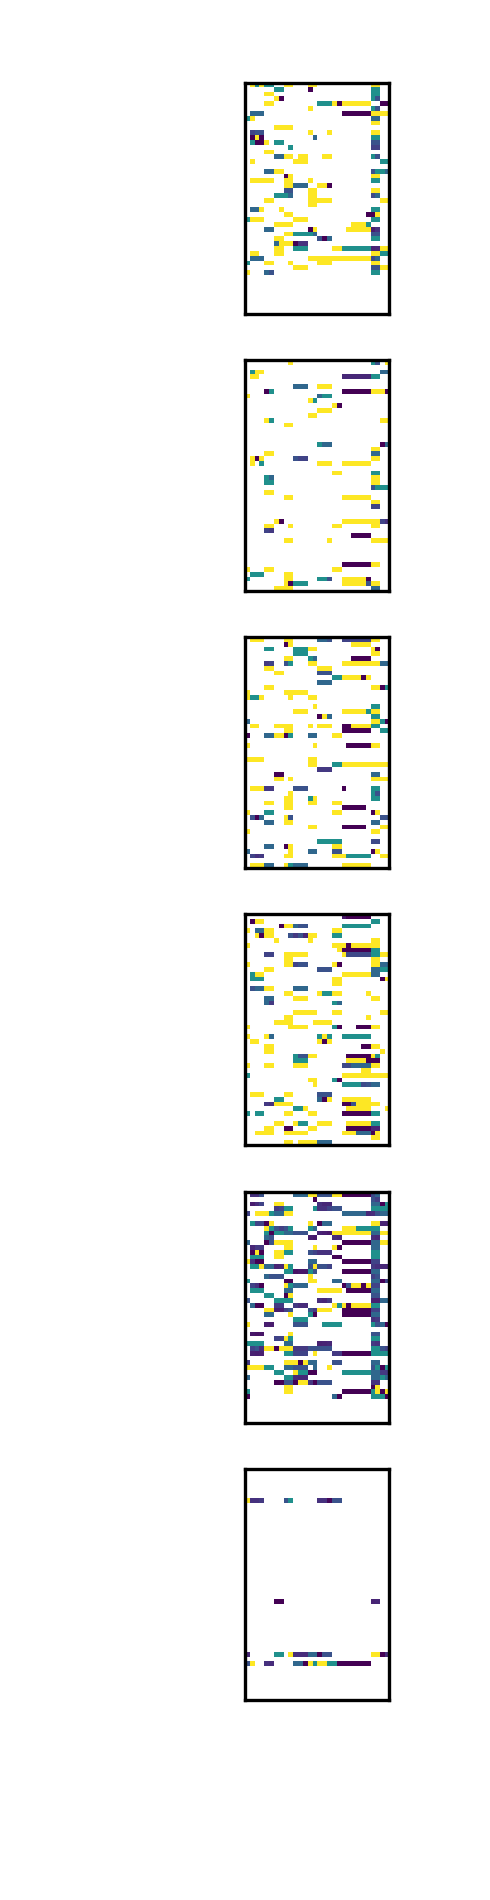

In [66]:
fig, ax = plt.subplots(len(mice),1,figsize=(1,7),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter][:,-30:])

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Th15_coreg_no_lasso_zoom_{direction}.png', format='png', dpi=300)
plt.show()

In [67]:
print(np.sum(idx_filter))
# print(idx_filter_stoch)

56


In [68]:
# cpgs_embryo = np.load('chosen_E55toE75_cpgs.npz')['cpgs']

FileNotFoundError: [Errno 2] No such file or directory: 'chosen_E55toE75_cpgs.npz'

# Figure 5

In [87]:
# cpgs_embryo = np.load('embryo_cpgs.npz')#['cpgs']
cpgs_embryo = np.load('embryo_cpgs_full.npz')#['cpgs']
cpgs_embryo = cpgs_embryo['cpgs']

In [88]:
cpgs = all_dsets.dsets['scMiceMuscle'].var.index[idx_s_nz].tolist()
# cpgs

In [89]:
# np.intersect1d(cpgs, cpgs_embryo).shape

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

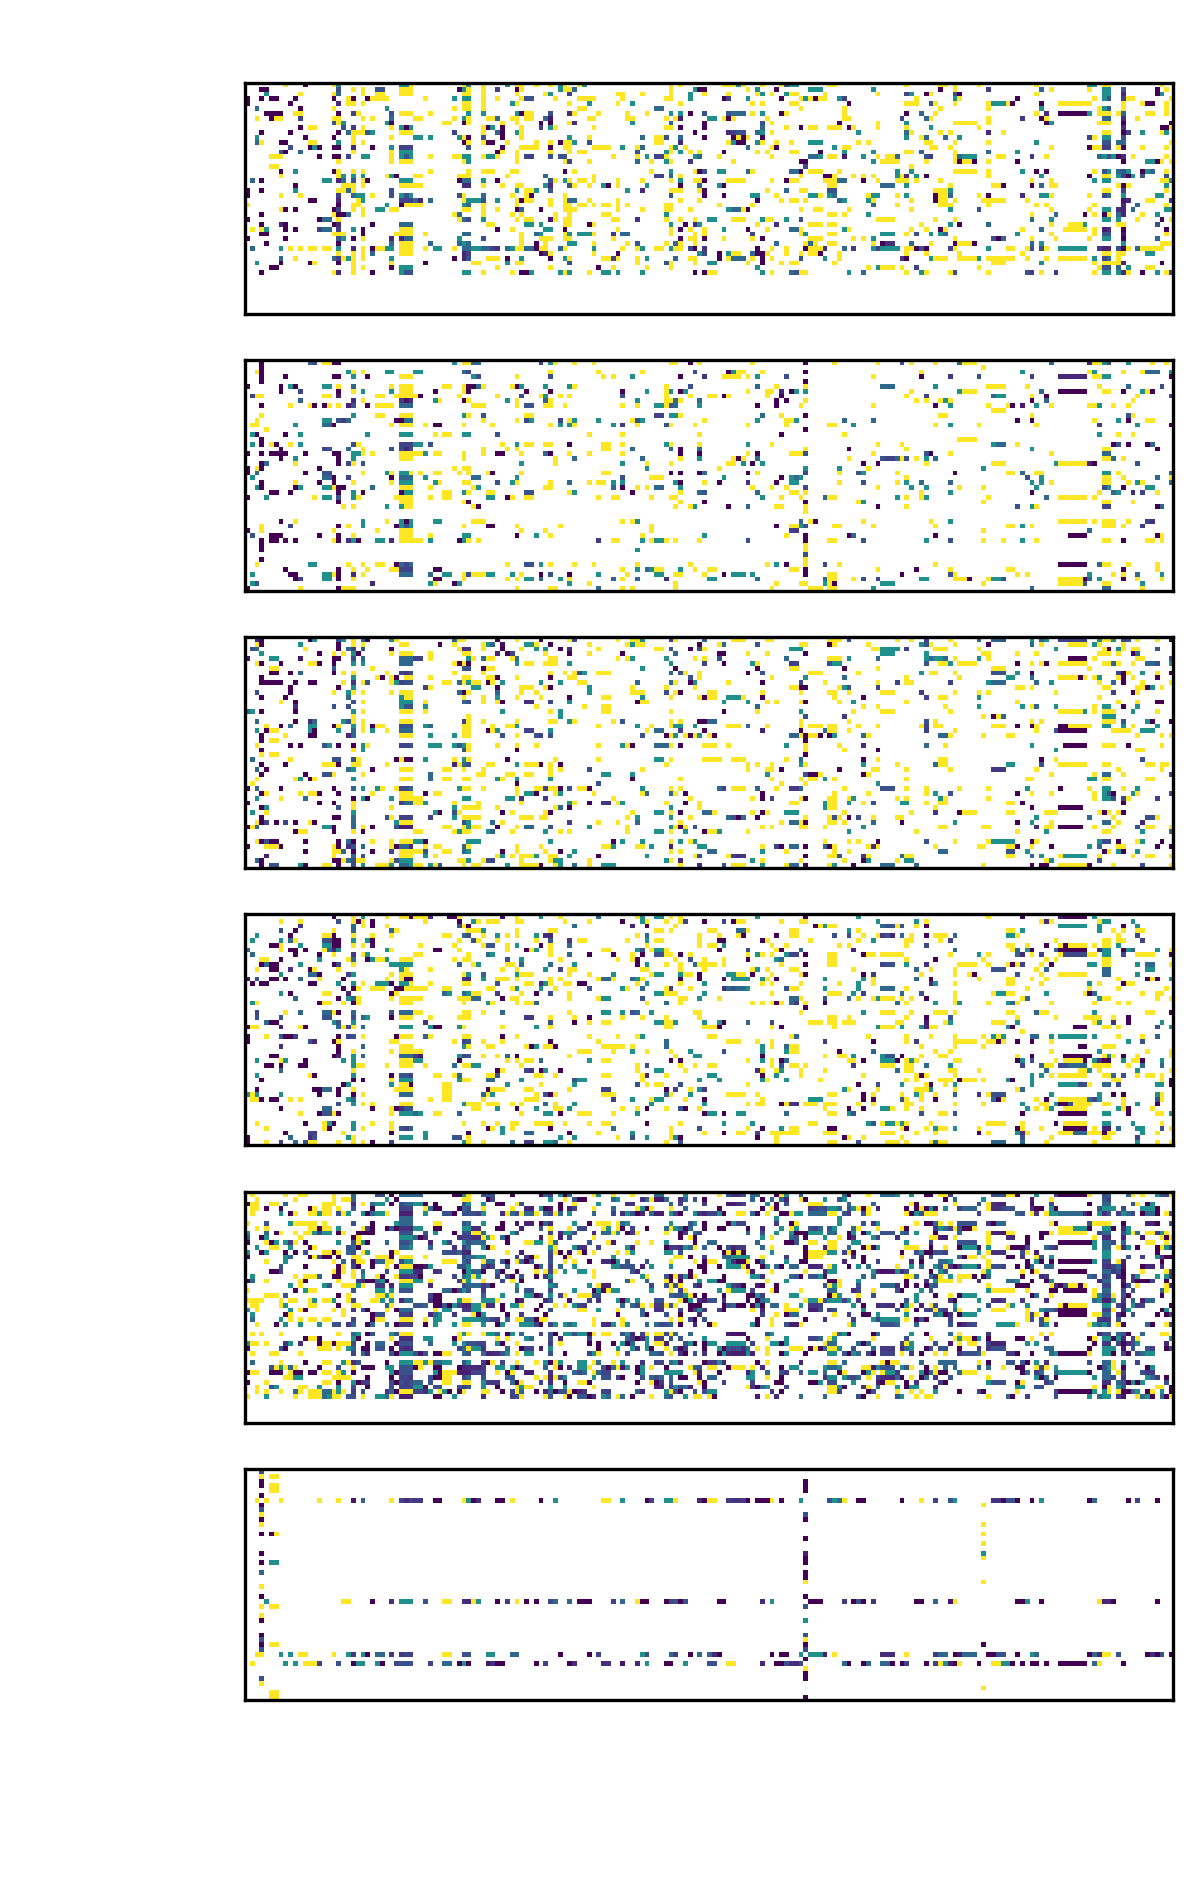

In [91]:
fig, ax = plt.subplots(len(mice),1,figsize=(7,7),
                       # figsize=figsize_for[direction],
                       dpi=300, sharex=True, sharey=True)
for i,mouse in enumerate(mice):
    jdx = params['Mouse_ID'].values == mouse
    xmouse = xpos[jdx,:]
    ax[i].imshow(xmouse[:,idx_filter_cut])

[ax[i].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False) for i in range(len(ax))]
plt.savefig(f'PICS/png/Fig5a_aging.png', format='png', dpi=300)
plt.show()